# Visualization

This notebook generates figures and tables **only from existing results** under `results/`. It does **not** re-run mining.

<details>
<summary><strong>Table of Contents</strong></summary>

1. [5.1 Experimental Protocol & Data Loading](#sec-5-1)
2. [5.2 Performance Analysis of Structural Optimizations](#sec-5-2)
3. [5.3 Verification of Concise Mining Efficiency](#sec-5-3)
4. [5.4 Empirical Ablation Studies](#sec-5-4)
5. [5.5 Search Space Reduction and Pruning Dynamics](#sec-5-5)
6. [5.6 Discovery Showcase](#sec-5-6)
7. [5.7 Top‑k Hybrid Summary](#sec-5-7)
</details>

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tracemalloc
import json
from pathlib import Path

In [6]:
RESULTS_DIR = Path("results")  
rows = []
for path in RESULTS_DIR.glob("comparison/**/run-avg.json"):
    data = json.loads(path.read_text())
    rows.append({
        "Algorithm": data.get("Algorithm"),
        "Dataset": data.get("Dataset"),
        "Runtime": data.get("Runtime"),
        "Peak_Memory": data.get("Peak_Memory"),
        "Patterns_Found": data.get("Patterns_Found"),
        "Candidates_Evaluated": data.get("Candidates_Evaluated"),
        "Pruned_Nodes": data.get("Pruned_Nodes"),
        "Wubocc_Pruned": data.get("Wubocc_Pruned"),
        "Total_Expanded": data.get("Total_Expanded"),
        "alpha": data.get("Params", {}).get("alpha"),
        "beta": data.get("Params", {}).get("beta"),
    })

comp_df = pd.DataFrame(rows)
comp_df.head()

,Algorithm,Dataset,Runtime,Peak_Memory,Patterns_Found,Candidates_Evaluated,Pruned_Nodes,Wubocc_Pruned,Total_Expanded,alpha,beta
0,HUOPM_Improved,Foodmart,3.000837,3.212644,399,399,0,0,399,0.0010,0.3
1,HUOPM_Improved,Foodmart,2.923408,3.257662,933,933,0,0,933,0.0010,0.2
2,HUOPM_Improved,Foodmart,3.141231,3.510873,2280,2280,0,0,2280,0.0005,0.3
3,HUOPM_Improved,Foodmart,3.542553,3.659213,3302,3302,0,0,3302,0.0005,0.2
4,HUOPM_Improved,Foodmart,0.023460,0.261814,12,12,0,0,12,0.0050,0.2


In [9]:
PALETTE = {
    "HUOPM": "#4E79A7",
    "HUOMIL": "#F28E2B",
    "HUOPM_Improved": "#59A14F",
    "CloFHUOIM": "#B279A2",
    "TopK_Hybrid": "#E15759"
}

<a id="sec-5-1"></a>
# 5.1 Experimental Protocol & Data Loading


DATASET STATISTICS
   Dataset  Transactions  Distinct Items  Avg Length  Max Length  Density (%)   Type
  Foodmart          4141            1559        4.42          14       0.2838 Sparse
  Mushroom          8416             119       23.00          23      19.3277  Dense
    Retail         88162           16470       10.31          76       0.0626 Sparse
Chainstore       1112949          910126       13.45         339       0.0015 Sparse


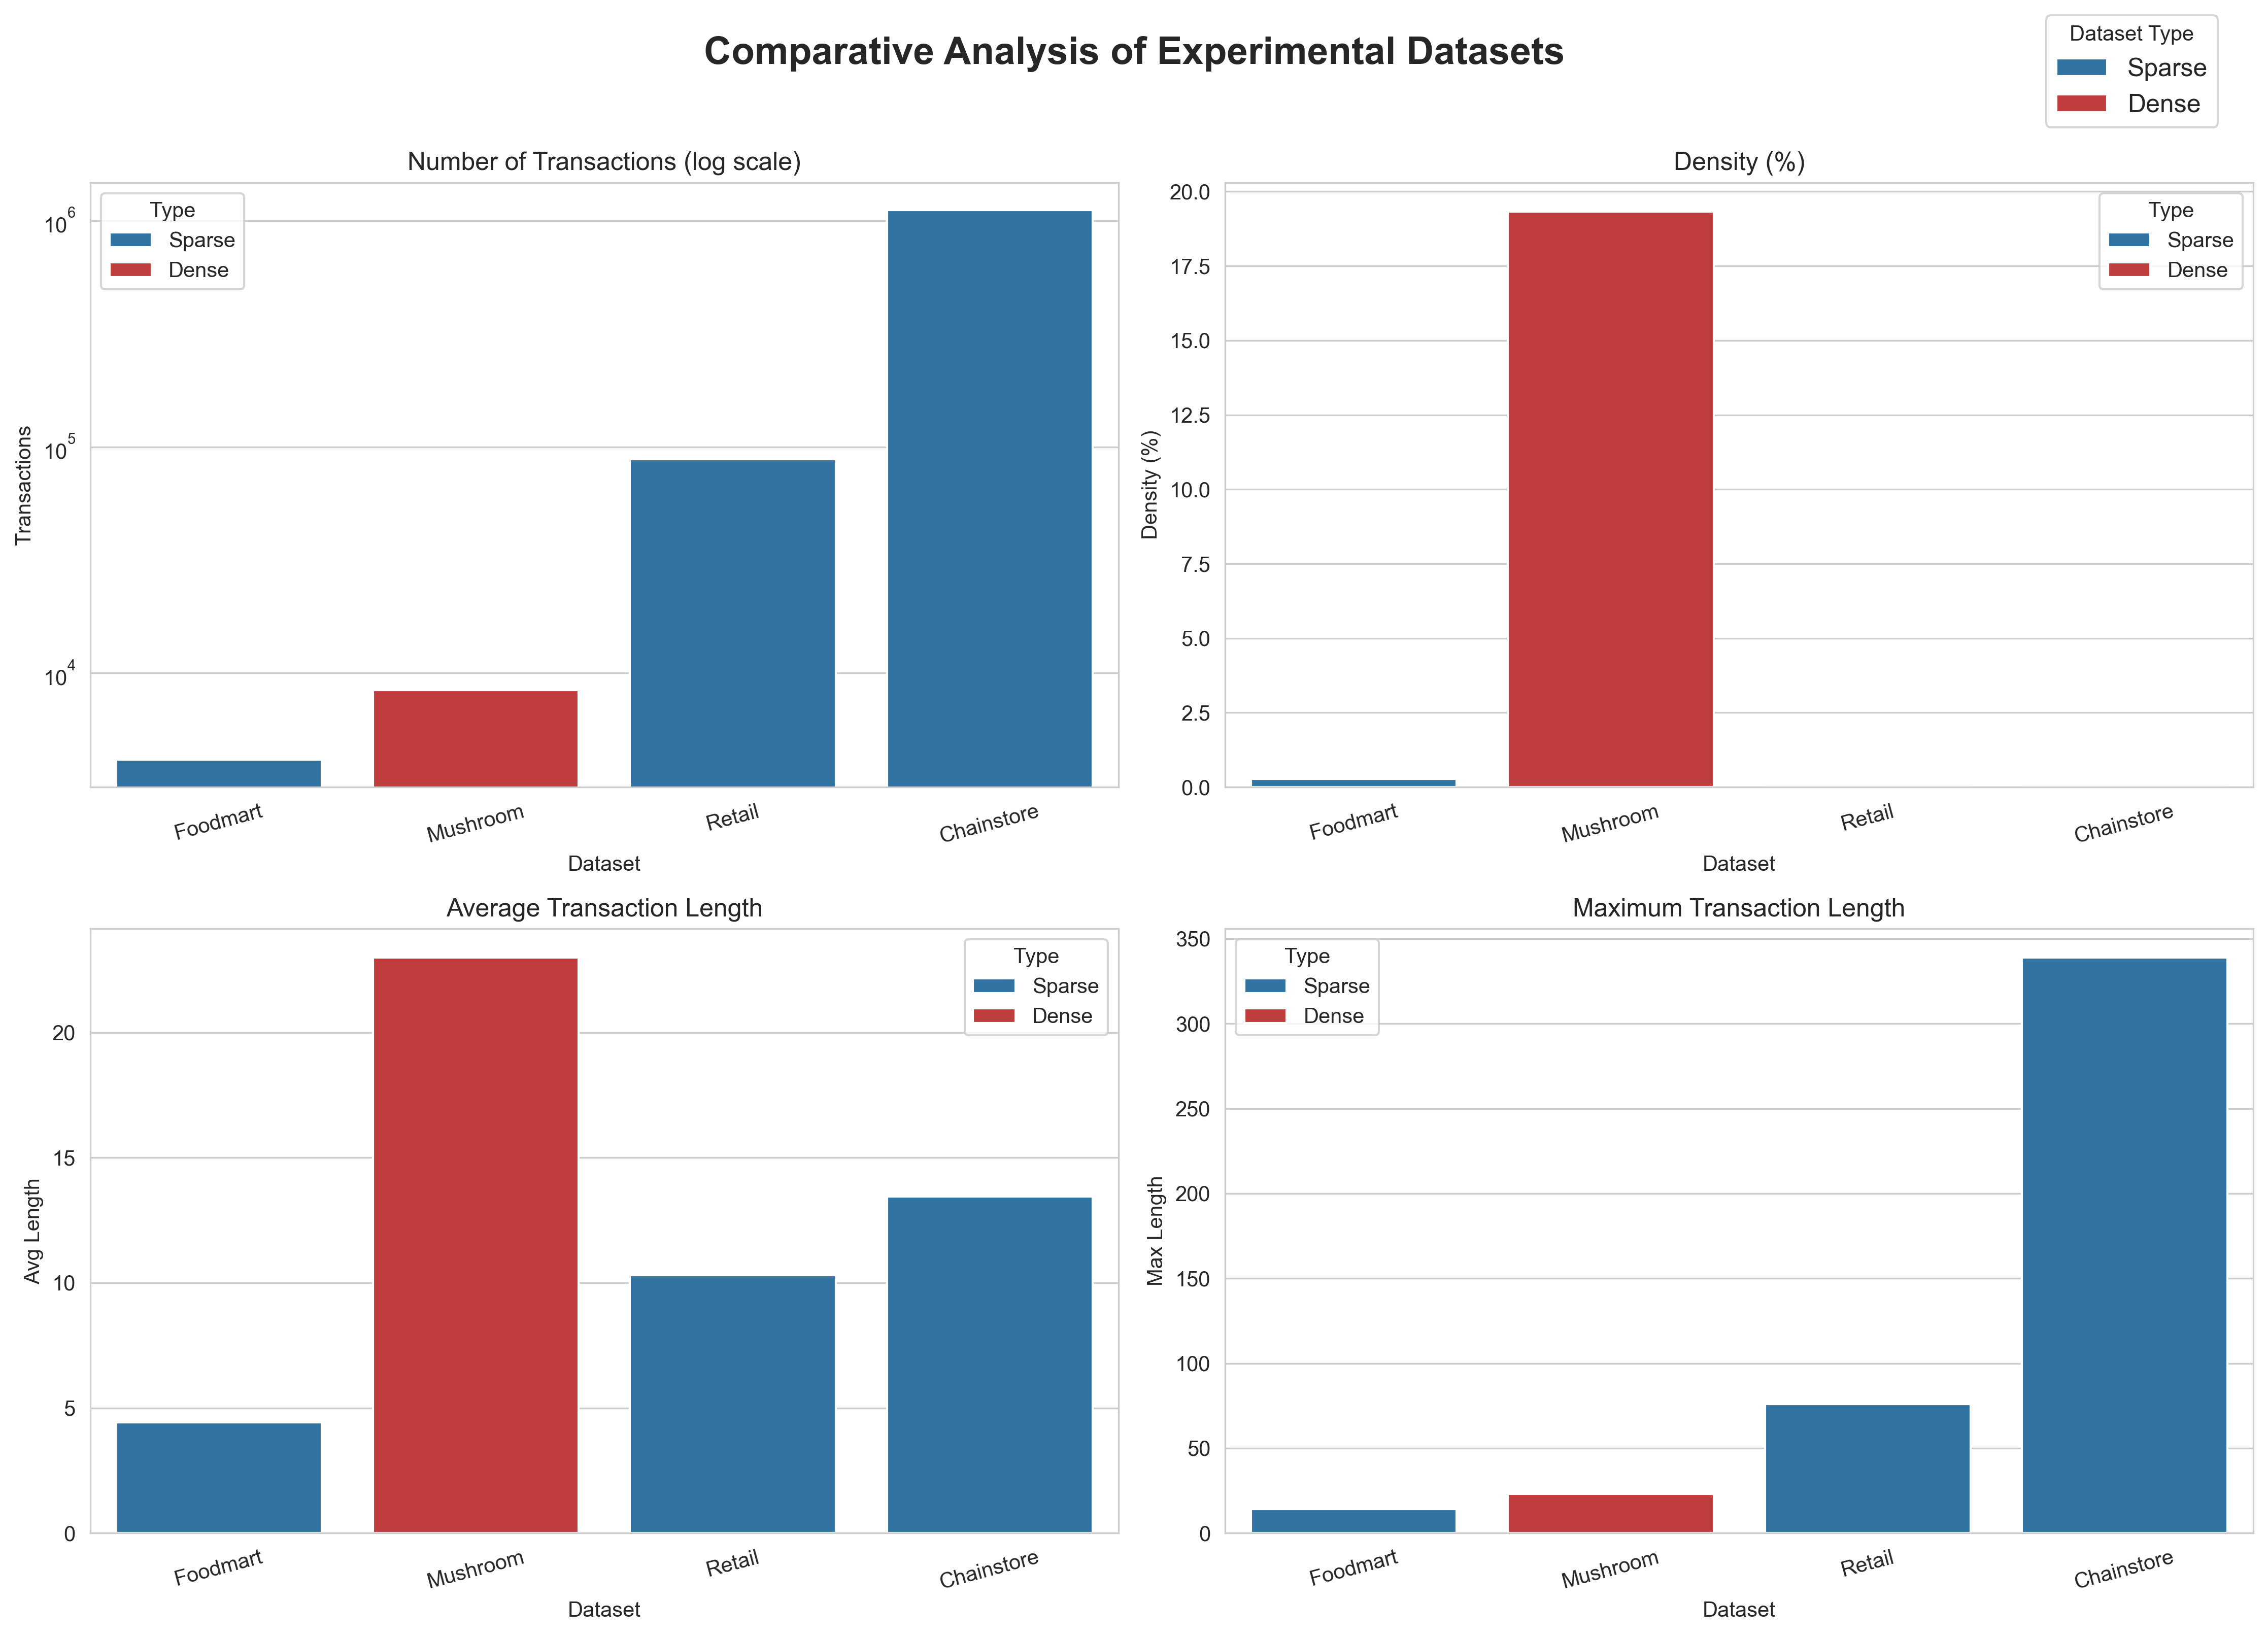

In [3]:
files = {
    'Foodmart': 'datasets/foodmartFIM.txt',
    'Mushroom': 'datasets/mushrooms.txt',
    'Retail':   'datasets/retail.txt',
    'Chainstore': 'datasets/chainstore.txt'
}

results = []

for name, path in files.items():
    with open(path, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    num_trans = len(lines)
    all_items = set()
    total_items = 0
    max_len = 0
    
    for line in lines:
        items = line.split()                    # space-separated items
        trans_len = len(items)
        total_items += trans_len
        max_len = max(max_len, trans_len)
        all_items.update(items)
    
    num_distinct = len(all_items)
    avg_len = round(total_items / num_trans, 2) if num_trans > 0 else 0
    density = round((total_items / (num_trans * num_distinct) * 100), 4) if num_distinct > 0 else 0
    
    results.append({
        'Dataset': name,
        'Transactions': num_trans,
        'Distinct Items': num_distinct,
        'Avg Length': avg_len,
        'Max Length': max_len,
        'Density (%)': density,
        'Type': 'Dense' if density > 5 else 'Sparse'
    })

df = pd.DataFrame(results)
print("DATASET STATISTICS")
print(df.to_string(index=False))

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 11))
fig.suptitle('Comparative Analysis of Experimental Datasets', 
             fontsize=18, fontweight='bold', y=0.96)

colors = {'Sparse': '#1f77b4', 'Dense': '#d62728'}   

# 1. Transactions (log scale)
sns.barplot(data=df, x='Dataset', y='Transactions', hue='Type', palette=colors, ax=axes[0,0])
axes[0,0].set_yscale('log')
axes[0,0].set_title('Number of Transactions (log scale)')
axes[0,0].set_ylabel('Transactions')
axes[0,0].tick_params(axis='x', rotation=15)

# 2. Density
sns.barplot(data=df, x='Dataset', y='Density (%)', hue='Type', palette=colors, ax=axes[0,1])
axes[0,1].set_title('Density (%)')
axes[0,1].set_ylabel('Density (%)')
axes[0,1].tick_params(axis='x', rotation=15)

# 3. Average Length
sns.barplot(data=df, x='Dataset', y='Avg Length', hue='Type', palette=colors, ax=axes[1,0])
axes[1,0].set_title('Average Transaction Length')
axes[1,0].set_ylabel('Avg Length')
axes[1,0].tick_params(axis='x', rotation=15)

# 4. Maximum Length
sns.barplot(data=df, x='Dataset', y='Max Length', hue='Type', palette=colors, ax=axes[1,1])
axes[1,1].set_title('Maximum Transaction Length')
axes[1,1].set_ylabel('Max Length')
axes[1,1].tick_params(axis='x', rotation=15)

# Legend
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, title='Dataset Type', loc='upper right', 
           bbox_to_anchor=(0.98, 0.98), fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.94])

plt.show()

<a id="sec-5-2"></a>
# 5.2 Performance Analysis of Structural Optimizations


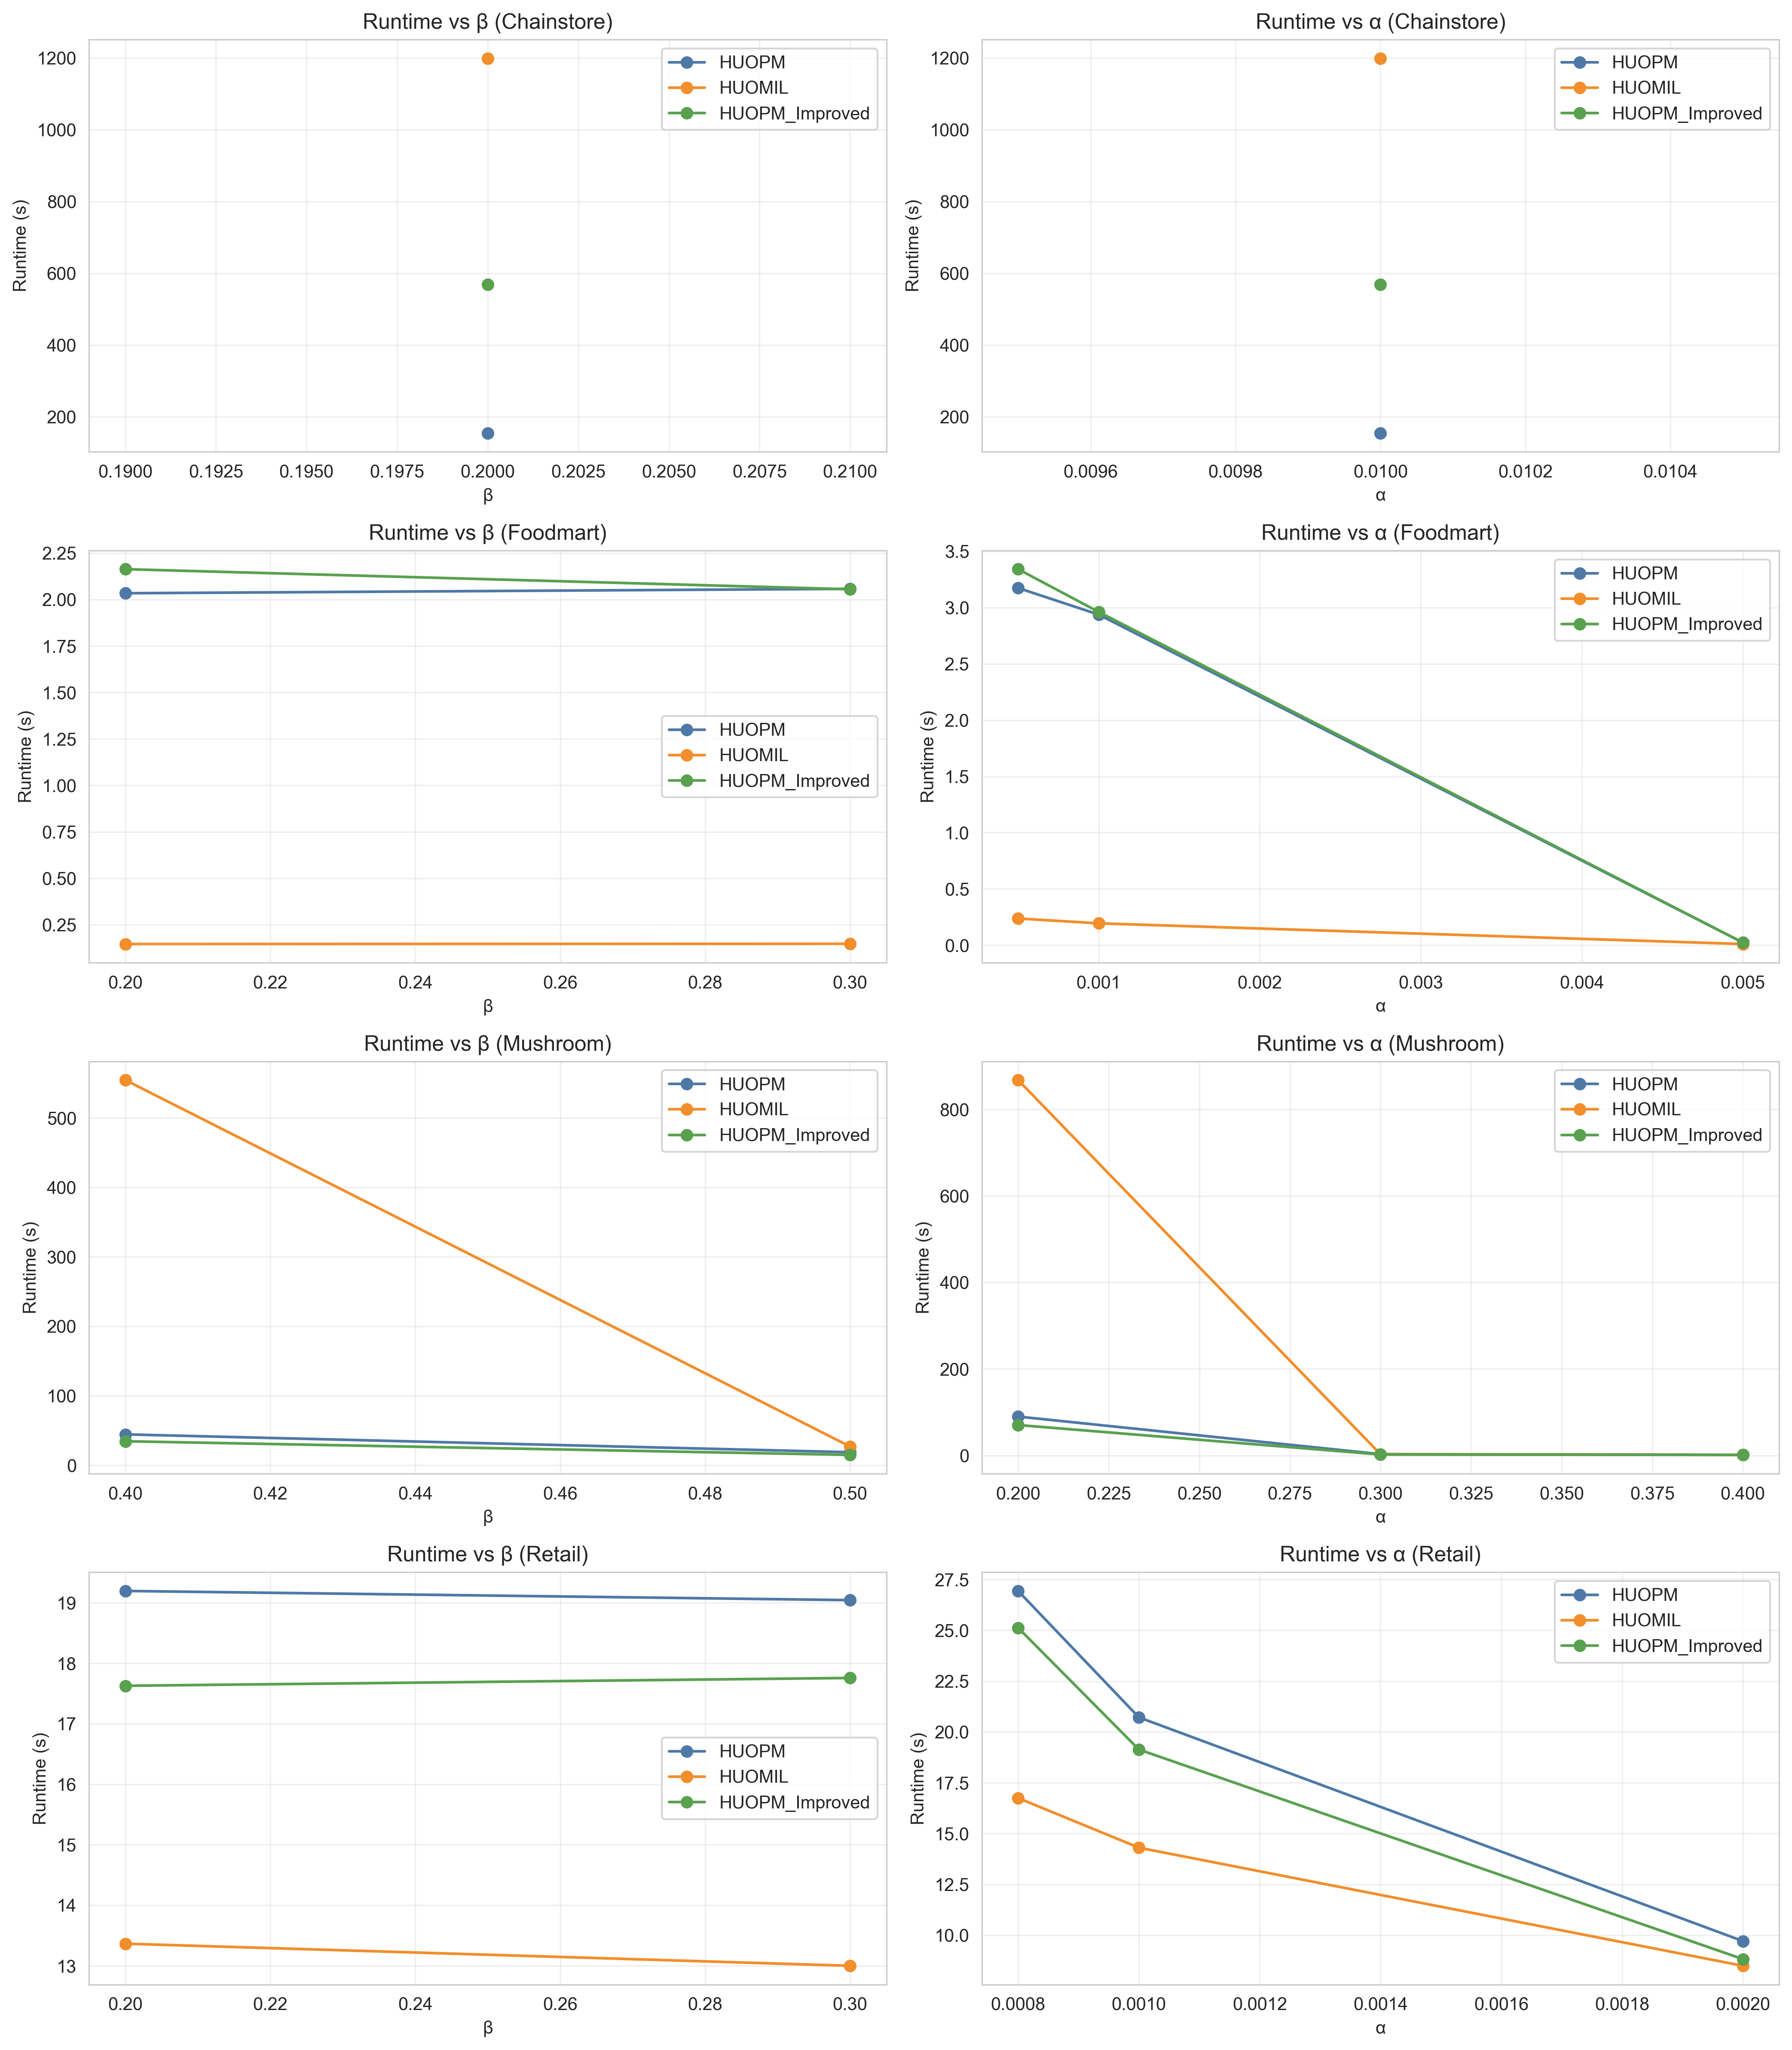

In [10]:
# 5.2.1 Runtime Sensitivity to Support (alpha) and Occupancy (beta)
plt.rcParams['figure.dpi'] = 300
algos = ['HUOPM', 'HUOMIL', 'HUOPM_Improved']
datasets = sorted(comp_df['Dataset'].unique())

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

plot_idx = 0

for dataset in datasets:
    sub = comp_df[comp_df['Dataset'] == dataset]
    if sub.empty:
        continue

    # --- Runtime vs beta ---
    ax = axes[plot_idx]
    for algo in algos:
        s = sub[sub['Algorithm'] == algo]
        if s.empty:
            continue
        grp = s.groupby('beta')['Runtime'].mean().reset_index().sort_values('beta')
        ax.plot(grp['beta'], grp['Runtime'], marker='o',
                label=algo, color=PALETTE.get(algo))
    ax.set_title(f'Runtime vs β ({dataset})')
    ax.set_xlabel('β')
    ax.set_ylabel('Runtime (s)')
    ax.grid(alpha=0.3)
    ax.legend()
    plot_idx += 1

    # --- Runtime vs alpha ---
    ax = axes[plot_idx]
    for algo in algos:
        s = sub[sub['Algorithm'] == algo]
        if s.empty:
            continue
        grp = s.groupby('alpha')['Runtime'].mean().reset_index().sort_values('alpha')
        ax.plot(grp['alpha'], grp['Runtime'], marker='o',
                label=algo, color=PALETTE.get(algo))
    ax.set_title(f'Runtime vs α ({dataset})')
    ax.set_xlabel('α')
    ax.set_ylabel('Runtime (s)')
    ax.grid(alpha=0.3)
    ax.legend()
    plot_idx += 1

plt.tight_layout()
plt.show()


**Key takeaways**
- Runtime rises sharply as α or β decreases because the search space expands.
- HUOPM_Improved generally stays below HUOPM, showing benefit from optimized joins and pruning.
- HUOMIL is strongest on sparse datasets where indexed navigation avoids expensive joins.


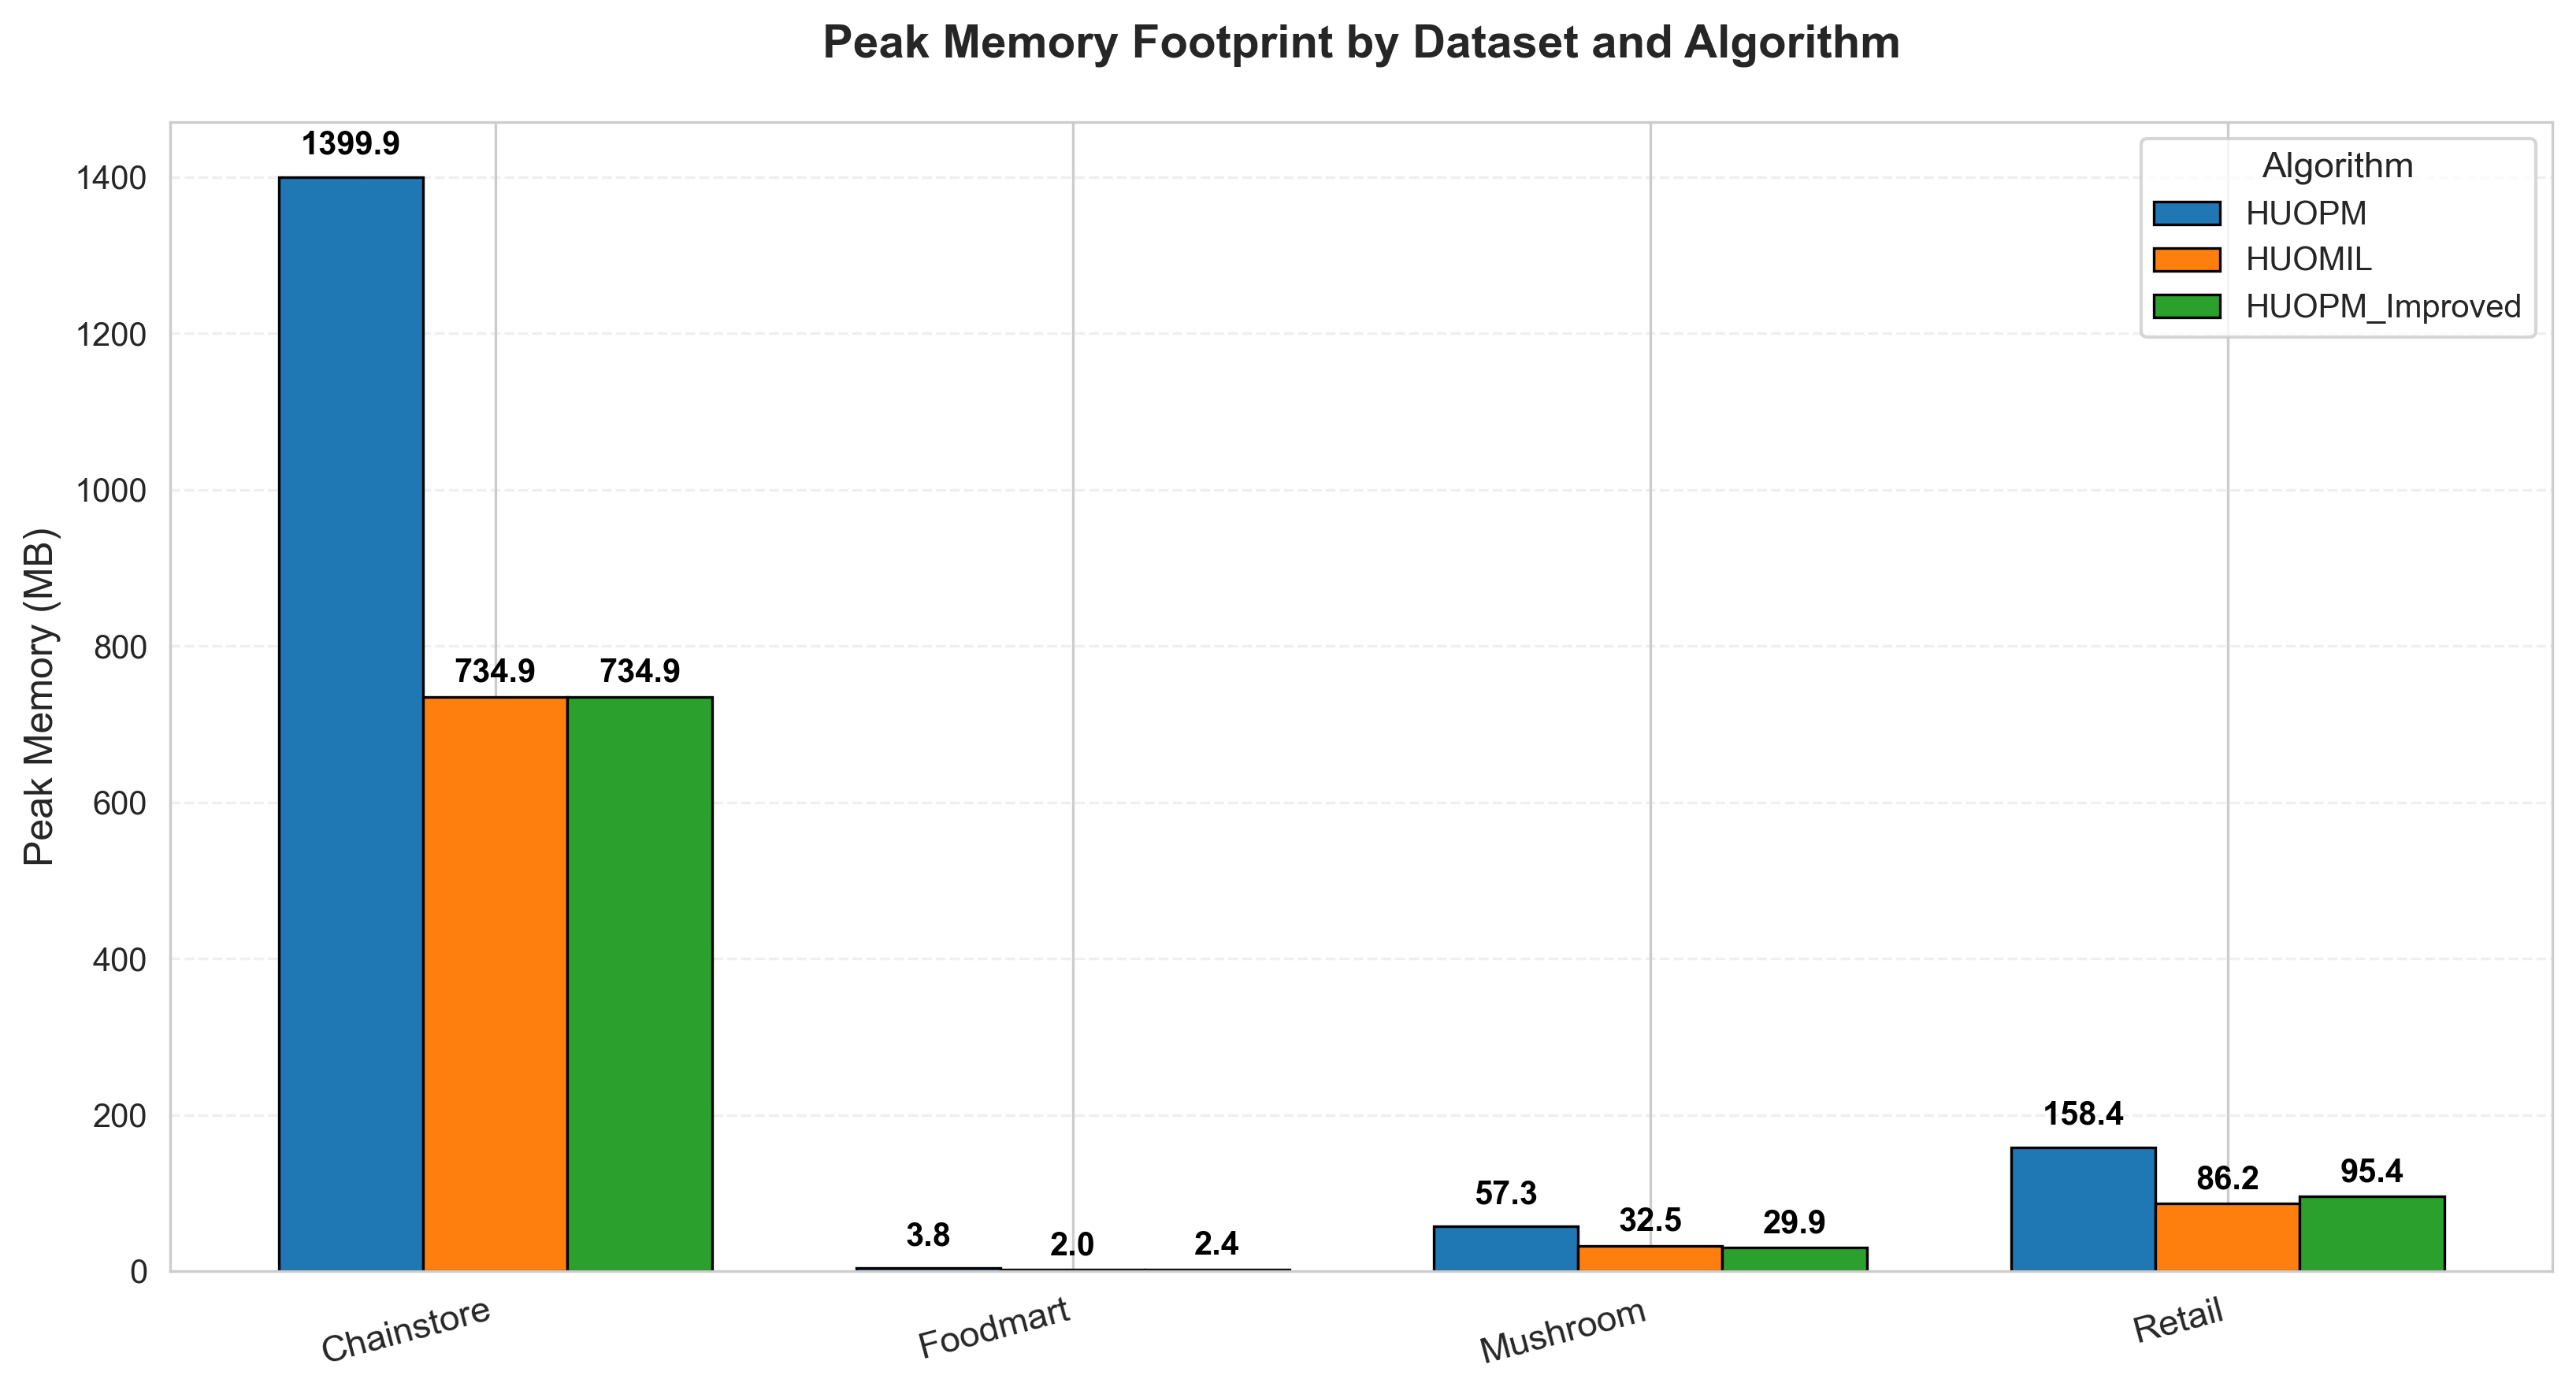

In [ ]:
# 5.2.2 Peak Memory Footprint 

# Compute average peak memory
avg_mem = comp_df.groupby(['Dataset', 'Algorithm'])['Peak_Memory'].mean().reset_index()

datasets = sorted(avg_mem['Dataset'].unique())
algos = ['HUOPM', 'HUOMIL', 'HUOPM_Improved']

# Professional color palette
PALETTE = {
    'HUOPM':          '#1f77b4',   # Blue
    'HUOMIL':         '#ff7f0e',   # Orange
    'HUOPM_Improved': '#2ca02c'    # Green
}

fig, ax = plt.subplots(figsize=(11, 6))   # Wider for better readability

width = 0.25
x = range(len(datasets))

for i, algo in enumerate(algos):
    vals = [
        avg_mem[(avg_mem['Dataset'] == d) & (avg_mem['Algorithm'] == algo)]['Peak_Memory'].mean()
        for d in datasets
    ]
    
    bars = ax.bar([p + i*width for p in x], vals, width, 
                  label=algo, color=PALETTE[algo], edgecolor='black', linewidth=0.8)
    
    # Horizontal numeric labels on top of bars
    for rect, v in zip(bars, vals):
        ax.text(rect.get_x() + rect.get_width()/2, 
                rect.get_height() + (max(vals)*0.015),   # small offset above bar
                f"{v:.1f}", 
                ha='center', va='bottom', 
                fontsize=10, fontweight='bold', color='black')

# Formatting
ax.set_xticks([p + width for p in x])   # center the group labels
ax.set_xticklabels(datasets, rotation=15, ha='right', fontsize=11)
ax.set_ylabel('Peak Memory (MB)', fontsize=12)
ax.set_title('Peak Memory Footprint by Dataset and Algorithm', fontsize=14, fontweight='bold', pad=20)

ax.legend(title='Algorithm', title_fontsize=11, fontsize=10, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

**Key takeaways**
- HUOPM_Improved consistently reduces peak RAM vs. HUOPM (`__slots__` + compact lists).
- Chainstore dominates the scale; numeric labels preserve readability across datasets.
- HUOMIL memory varies with density due to pointer-based structures.


<a id="sec-5-3"></a>
# 5.3 Verification of Concise Mining Efficiency


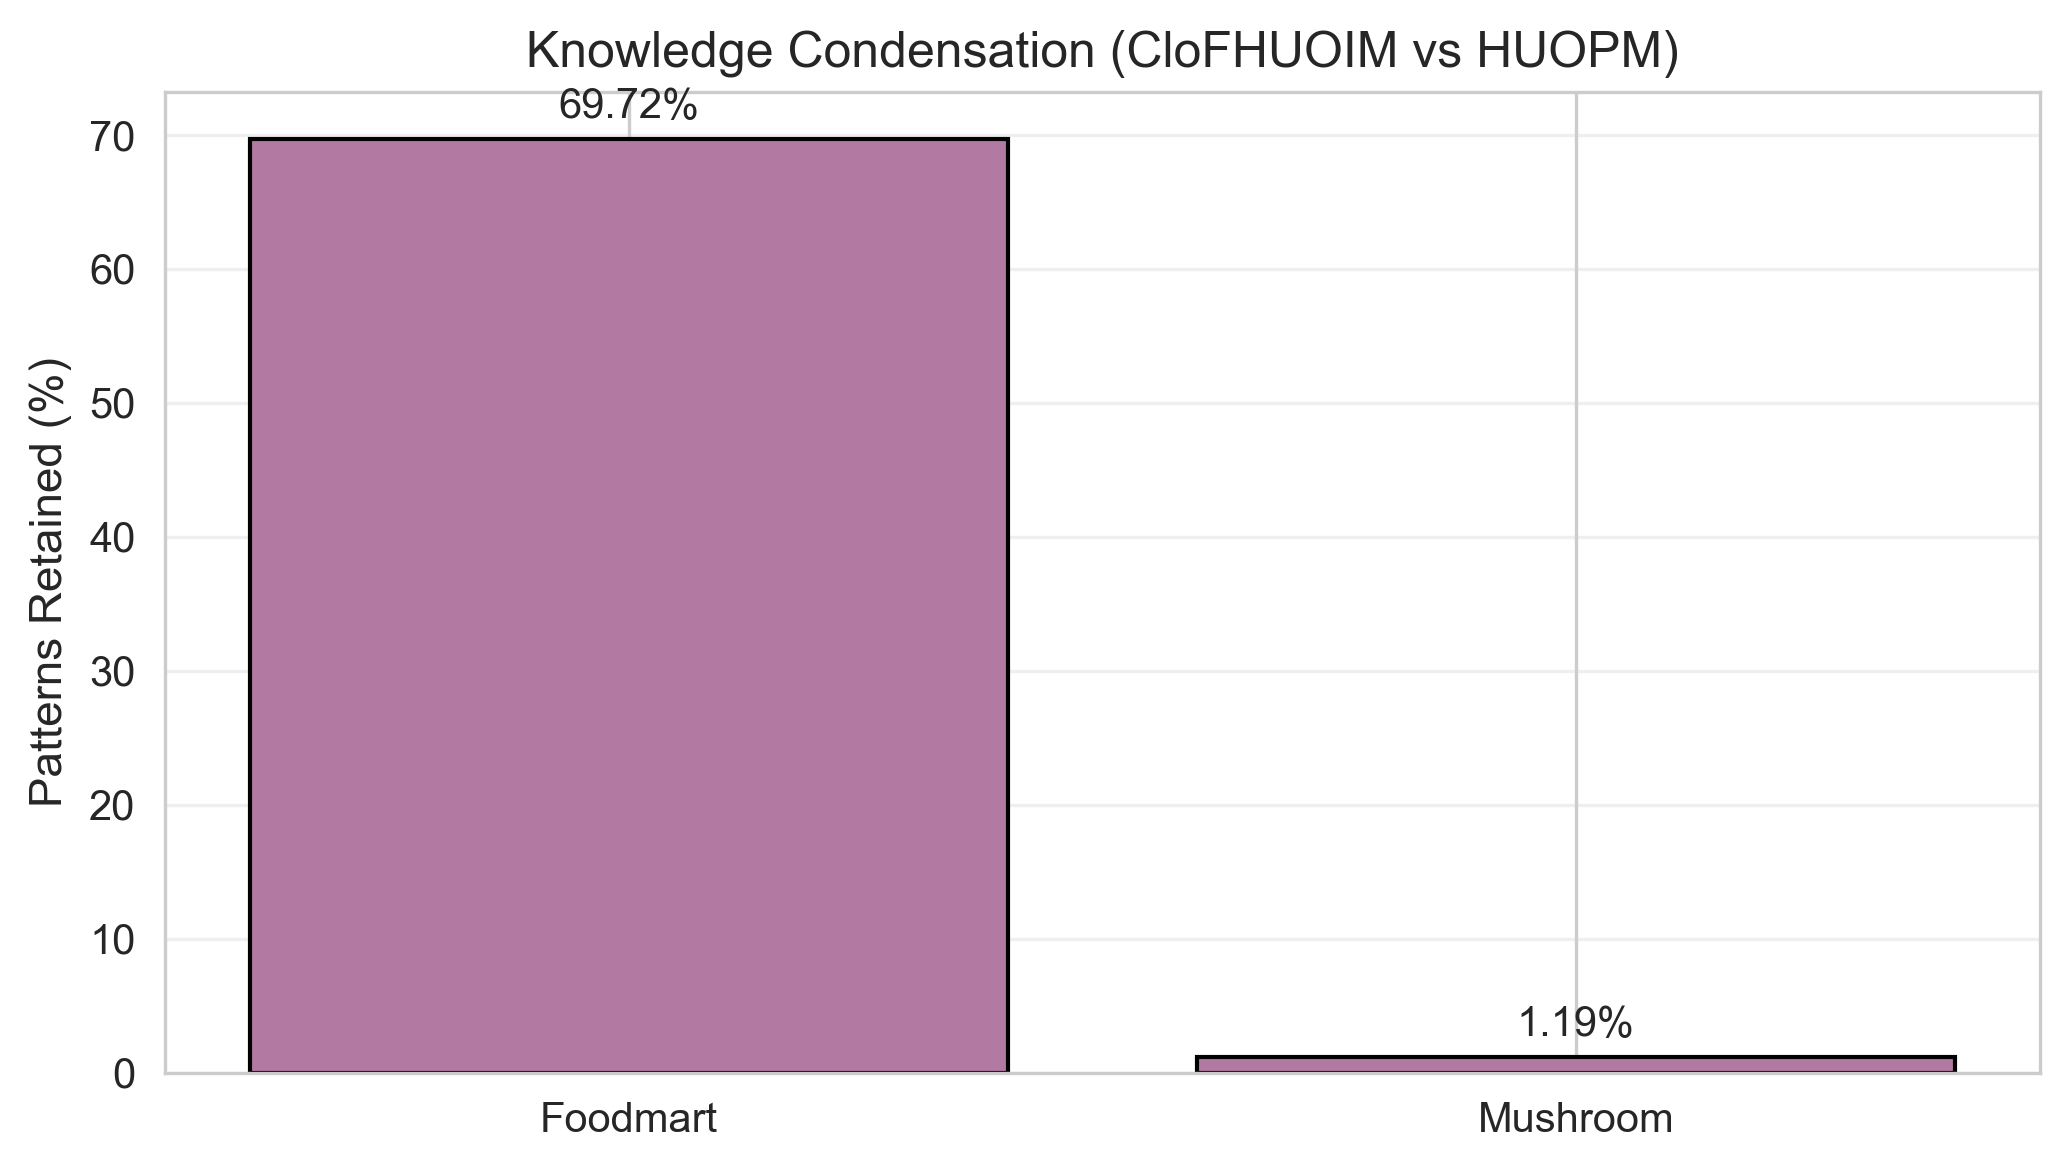

In [ ]:
# 5.3.1 Compression Ratio: CloFHUOIM vs HUOPM
valid = merged[merged['Patterns_Found_clo'] <= merged['Patterns_Found_huopm']]

ratio_avg = valid.groupby('Dataset')['Retention_Percentage'].mean().reset_index()

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(ratio_avg['Dataset'], ratio_avg['Retention_Percentage'], color='#B279A2', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

ax.set_ylabel('Patterns Retained (%)')
ax.set_title('Knowledge Condensation (CloFHUOIM vs HUOPM)')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Key takeaways**
- Only valid configurations (CloFHUOIM ≤ HUOPM) are included in the ratio.
- Dense datasets (e.g., Mushroom) show the strongest compression.
- Confirms closed patterns remove redundancy while preserving information.


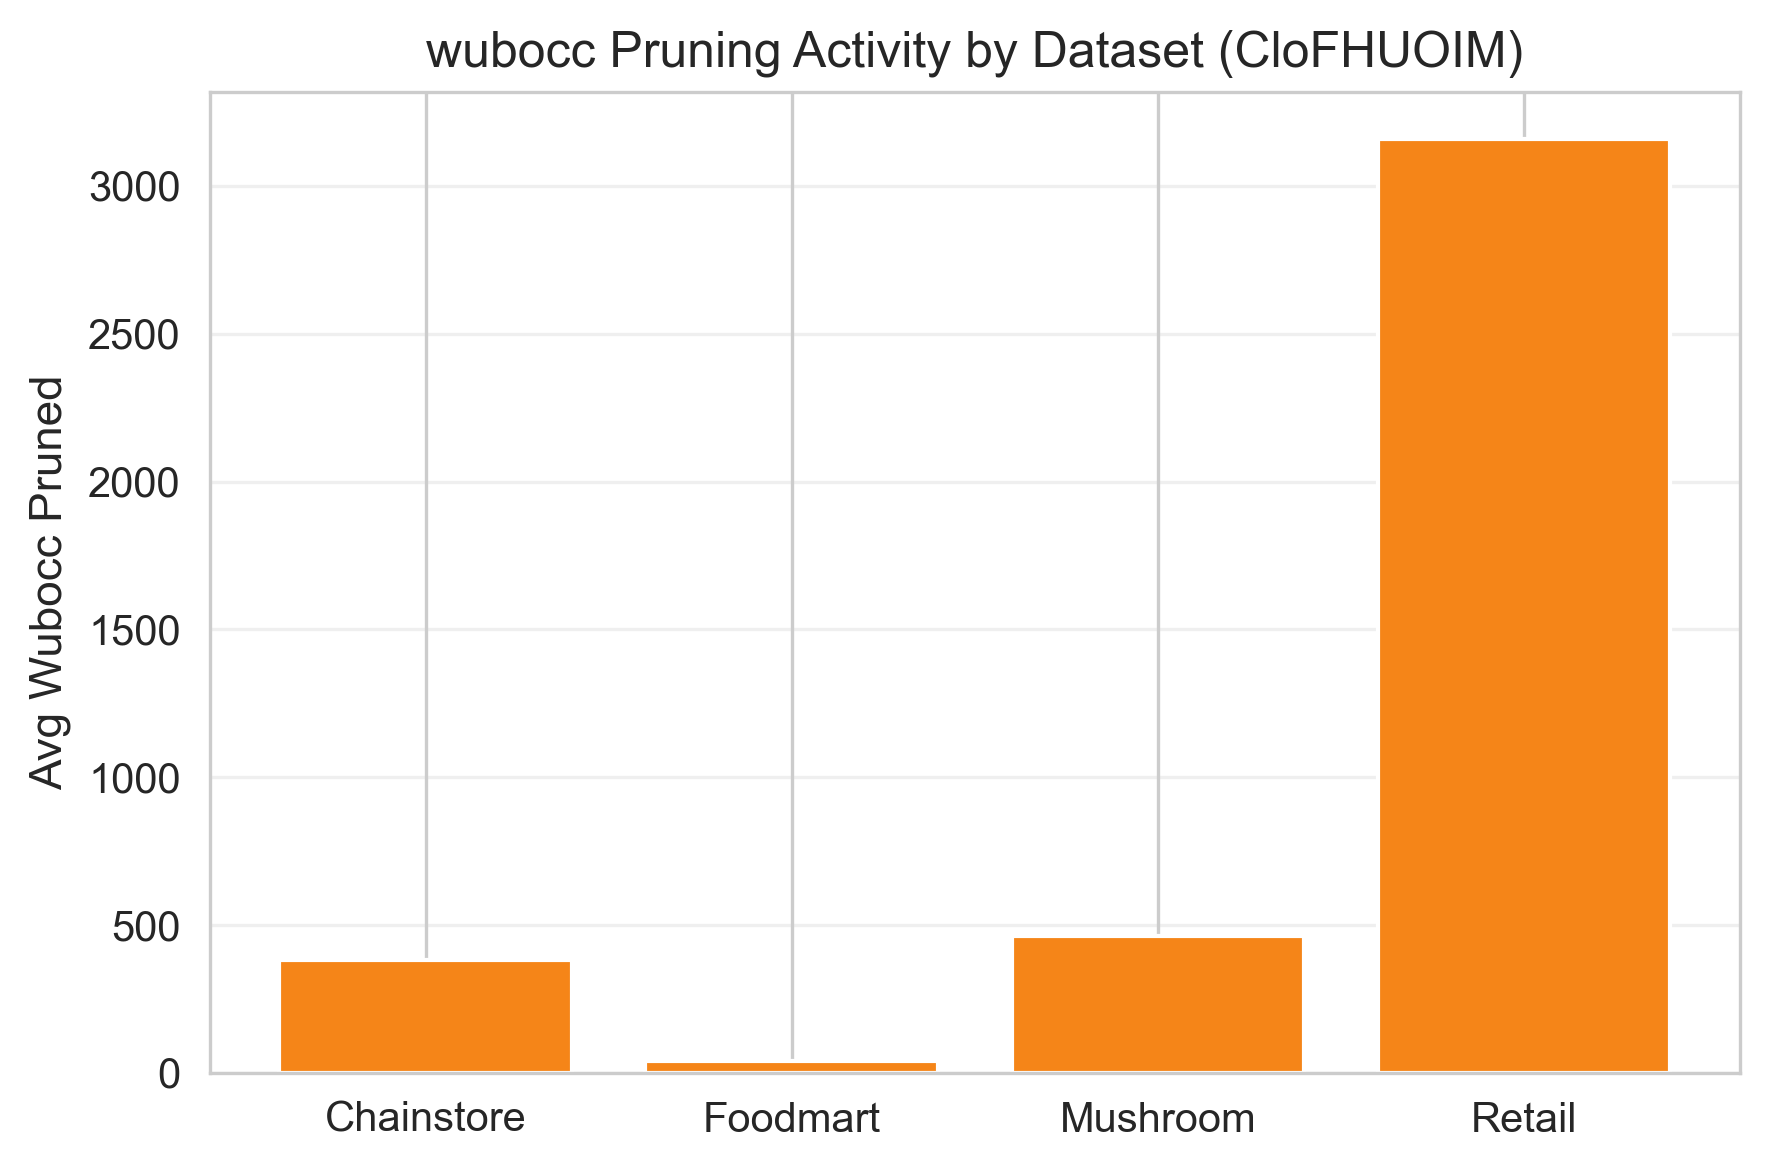

In [ ]:
# 5.3.2 wubocc Pruning Effect (SDPS pruning counts)

wub = concise_df.groupby('Dataset')['Wubocc_Pruned'].mean().reset_index()

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(wub['Dataset'], wub['Wubocc_Pruned'], color='#F58518')
ax.set_ylabel('Avg Wubocc Pruned')
ax.set_title('wubocc Pruning Activity by Dataset (CloFHUOIM)')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Key takeaways**
- `wubocc` pruning is most active in dense or very large search spaces.
- Retail shows high pruning counts due to massive item space; Foodmart remains low.
- SDPS provides strong early pruning without sacrificing correctness.


<a id="sec-5-4"></a>
# 5.4 Empirical Ablation Studies


             Variant  Peak_Memory_MB  Savings_%
0     With __slots__       18.507991  38.215251
1  Without __slots__       29.955598   0.000000


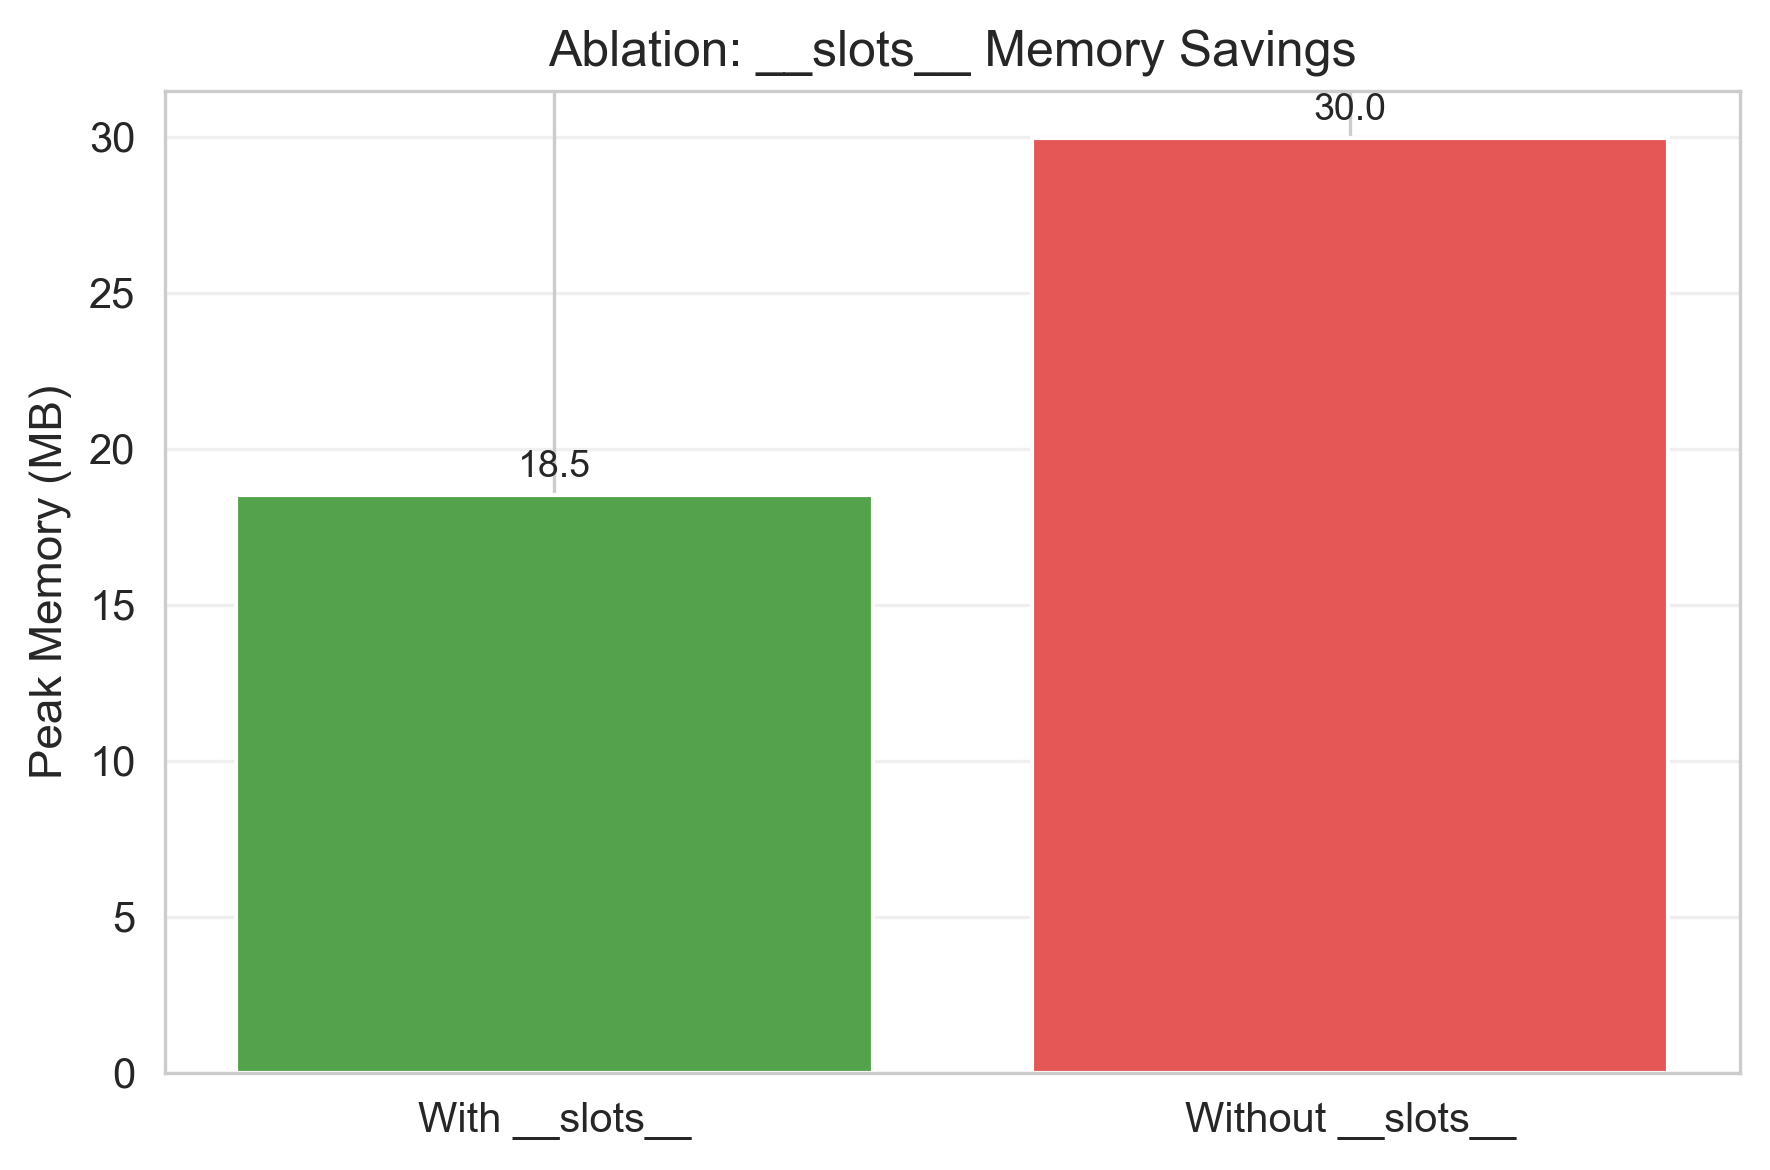

In [ ]:
# 5.4.1 __slots__ Memory Ablation
class NodeWithSlots:
    __slots__ = ("a", "b", "c")
    def __init__(self, a, b, c):
        self.a, self.b, self.c = a, b, c

class NodeWithoutSlots:
    def __init__(self, a, b, c):
        self.a, self.b, self.c = a, b, c

def measure_memory(cls, n=300_000):
    tracemalloc.start()
    nodes = [cls(1,2,3) for _ in range(n)]
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    _ = nodes[0]
    return peak / (1024*1024)

N = 300_000  
mem_slots = measure_memory(NodeWithSlots, n=N)
mem_no = measure_memory(NodeWithoutSlots, n=N)

df = pd.DataFrame({
    "Variant": ["With __slots__", "Without __slots__"],
    "Peak_Memory_MB": [mem_slots, mem_no]
})
df["Savings_%"] = (1 - df["Peak_Memory_MB"] / df["Peak_Memory_MB"].max()) * 100
print(df)

# Bar chart
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(df["Variant"], df["Peak_Memory_MB"], color=["#54A24B", "#E45756"])
ax.set_ylabel("Peak Memory (MB)")
ax.set_title("Ablation: __slots__ Memory Savings")
for i, v in enumerate(df["Peak_Memory_MB"]):
    ax.text(i, v + max(df["Peak_Memory_MB"])*0.02, f"{v:.1f}", ha="center", fontsize=9)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


**Key takeaways**
- The `__slots__` ablation shows substantial peak‑memory reduction at node level.
- This explains the large RAM savings observed in HUOPM_Improved on full datasets.


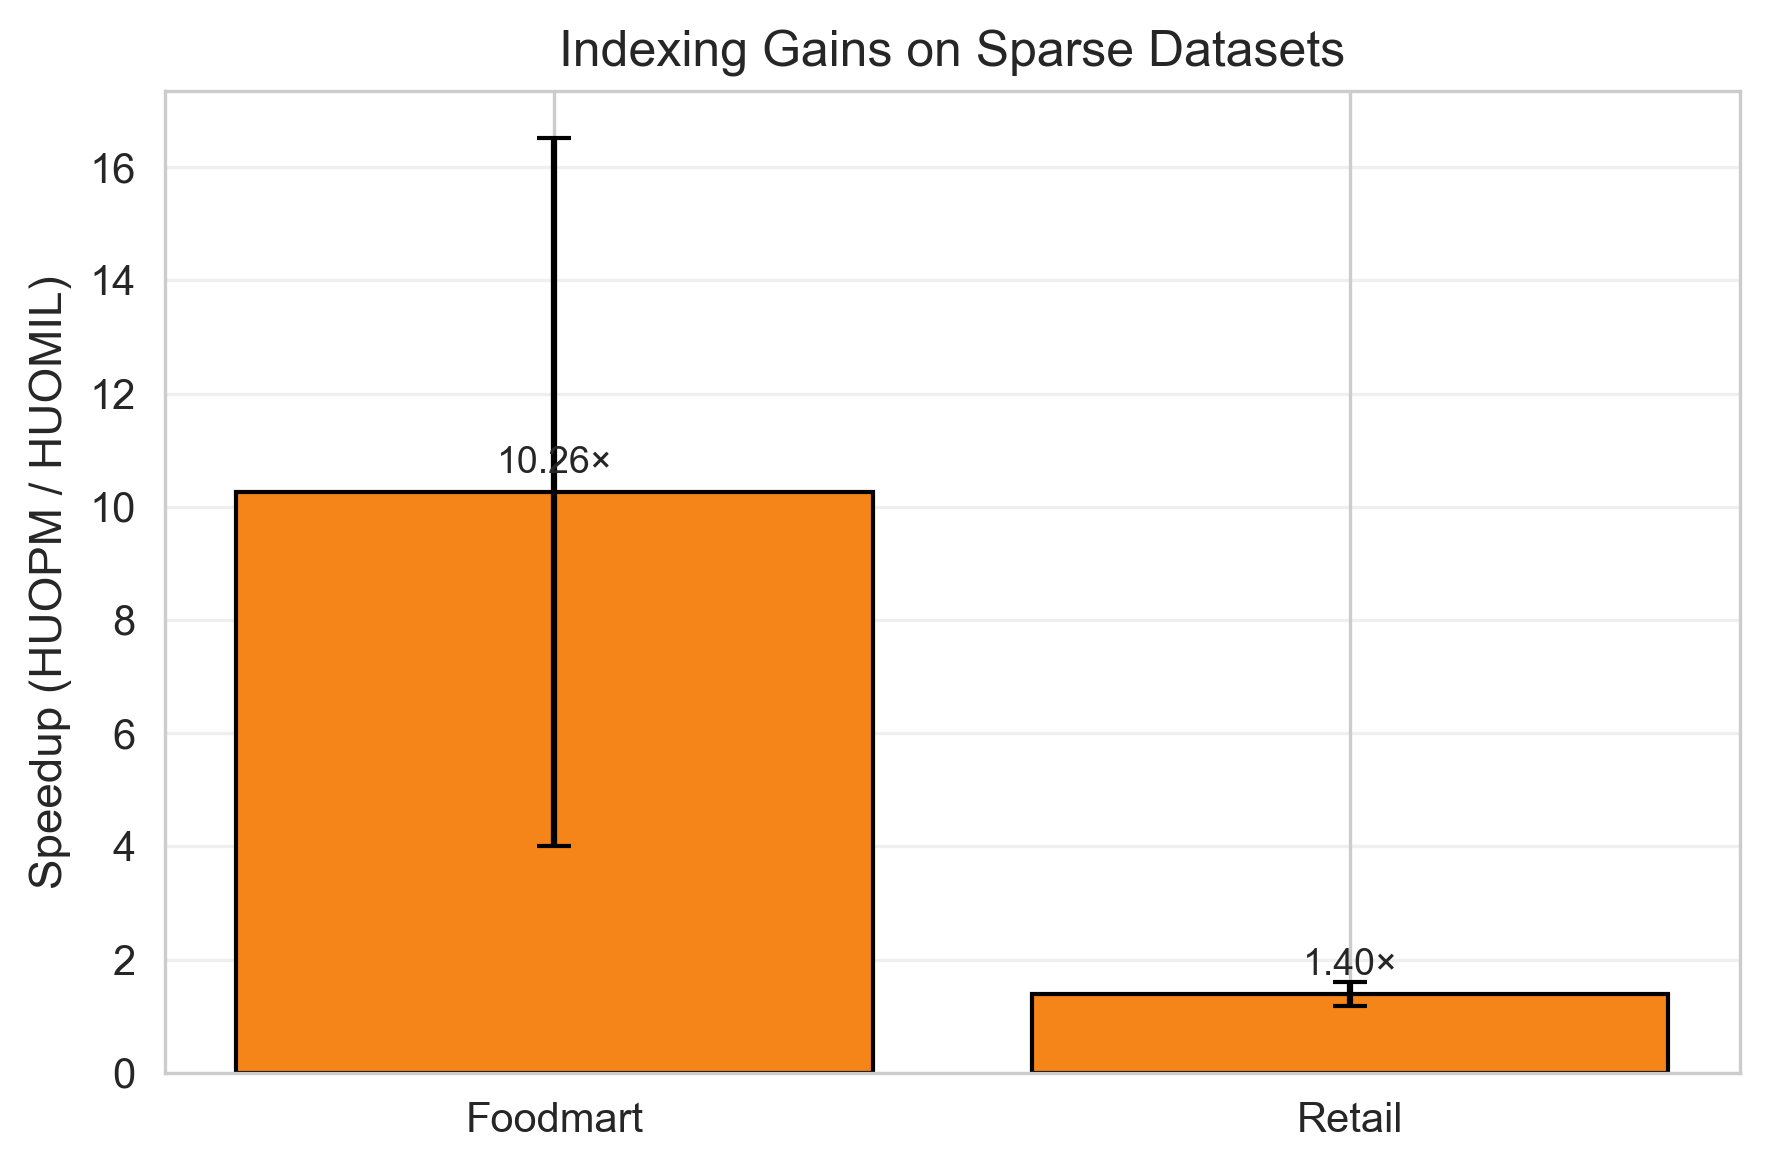

In [ ]:
# 5.4.2 Structural Indexing Gains (HUOMIL vs HUOPM) 
sparse_datasets = ["Retail", "Foodmart"]

sub = comp_df[comp_df["Dataset"].isin(sparse_datasets)]
huopm = sub[sub["Algorithm"] == "HUOPM"]
huomil = sub[sub["Algorithm"] == "HUOMIL"]

merged = pd.merge(
    huopm, huomil,
    on=["Dataset", "alpha", "beta"],
    suffixes=("_huopm", "_huomil")
)

merged["Speedup_HUOMIL"] = merged["Runtime_huopm"] / merged["Runtime_huomil"]

# mean + std for error bars
speedup_stats = merged.groupby("Dataset")["Speedup_HUOMIL"].agg(["mean", "std"]).reset_index()

fig, ax = plt.subplots(figsize=(6,4))

bars = ax.bar(
    speedup_stats["Dataset"],
    speedup_stats["mean"],
    yerr=speedup_stats["std"],
    capsize=4,
    color="#F58518",
    edgecolor="black"
)

ax.set_ylabel("Speedup (HUOPM / HUOMIL)")
ax.set_title("Indexing Gains on Sparse Datasets")
ax.grid(axis='y', alpha=0.3)

# add labels above bars
for bar, val in zip(bars, speedup_stats["mean"]):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + max(speedup_stats["mean"])*0.02,
        f"{val:.2f}×",
        ha="center", va="bottom", fontsize=9
    )

plt.tight_layout()
plt.show()


**Key takeaways**
- HUOMIL achieves strong speedups on sparse datasets (Foodmart, Retail).
- Indexing trades runtime gains for higher structural overhead in dense data.


<a id="sec-5-5"></a>
# 5.5 Search Space Reduction and Pruning Dynamics


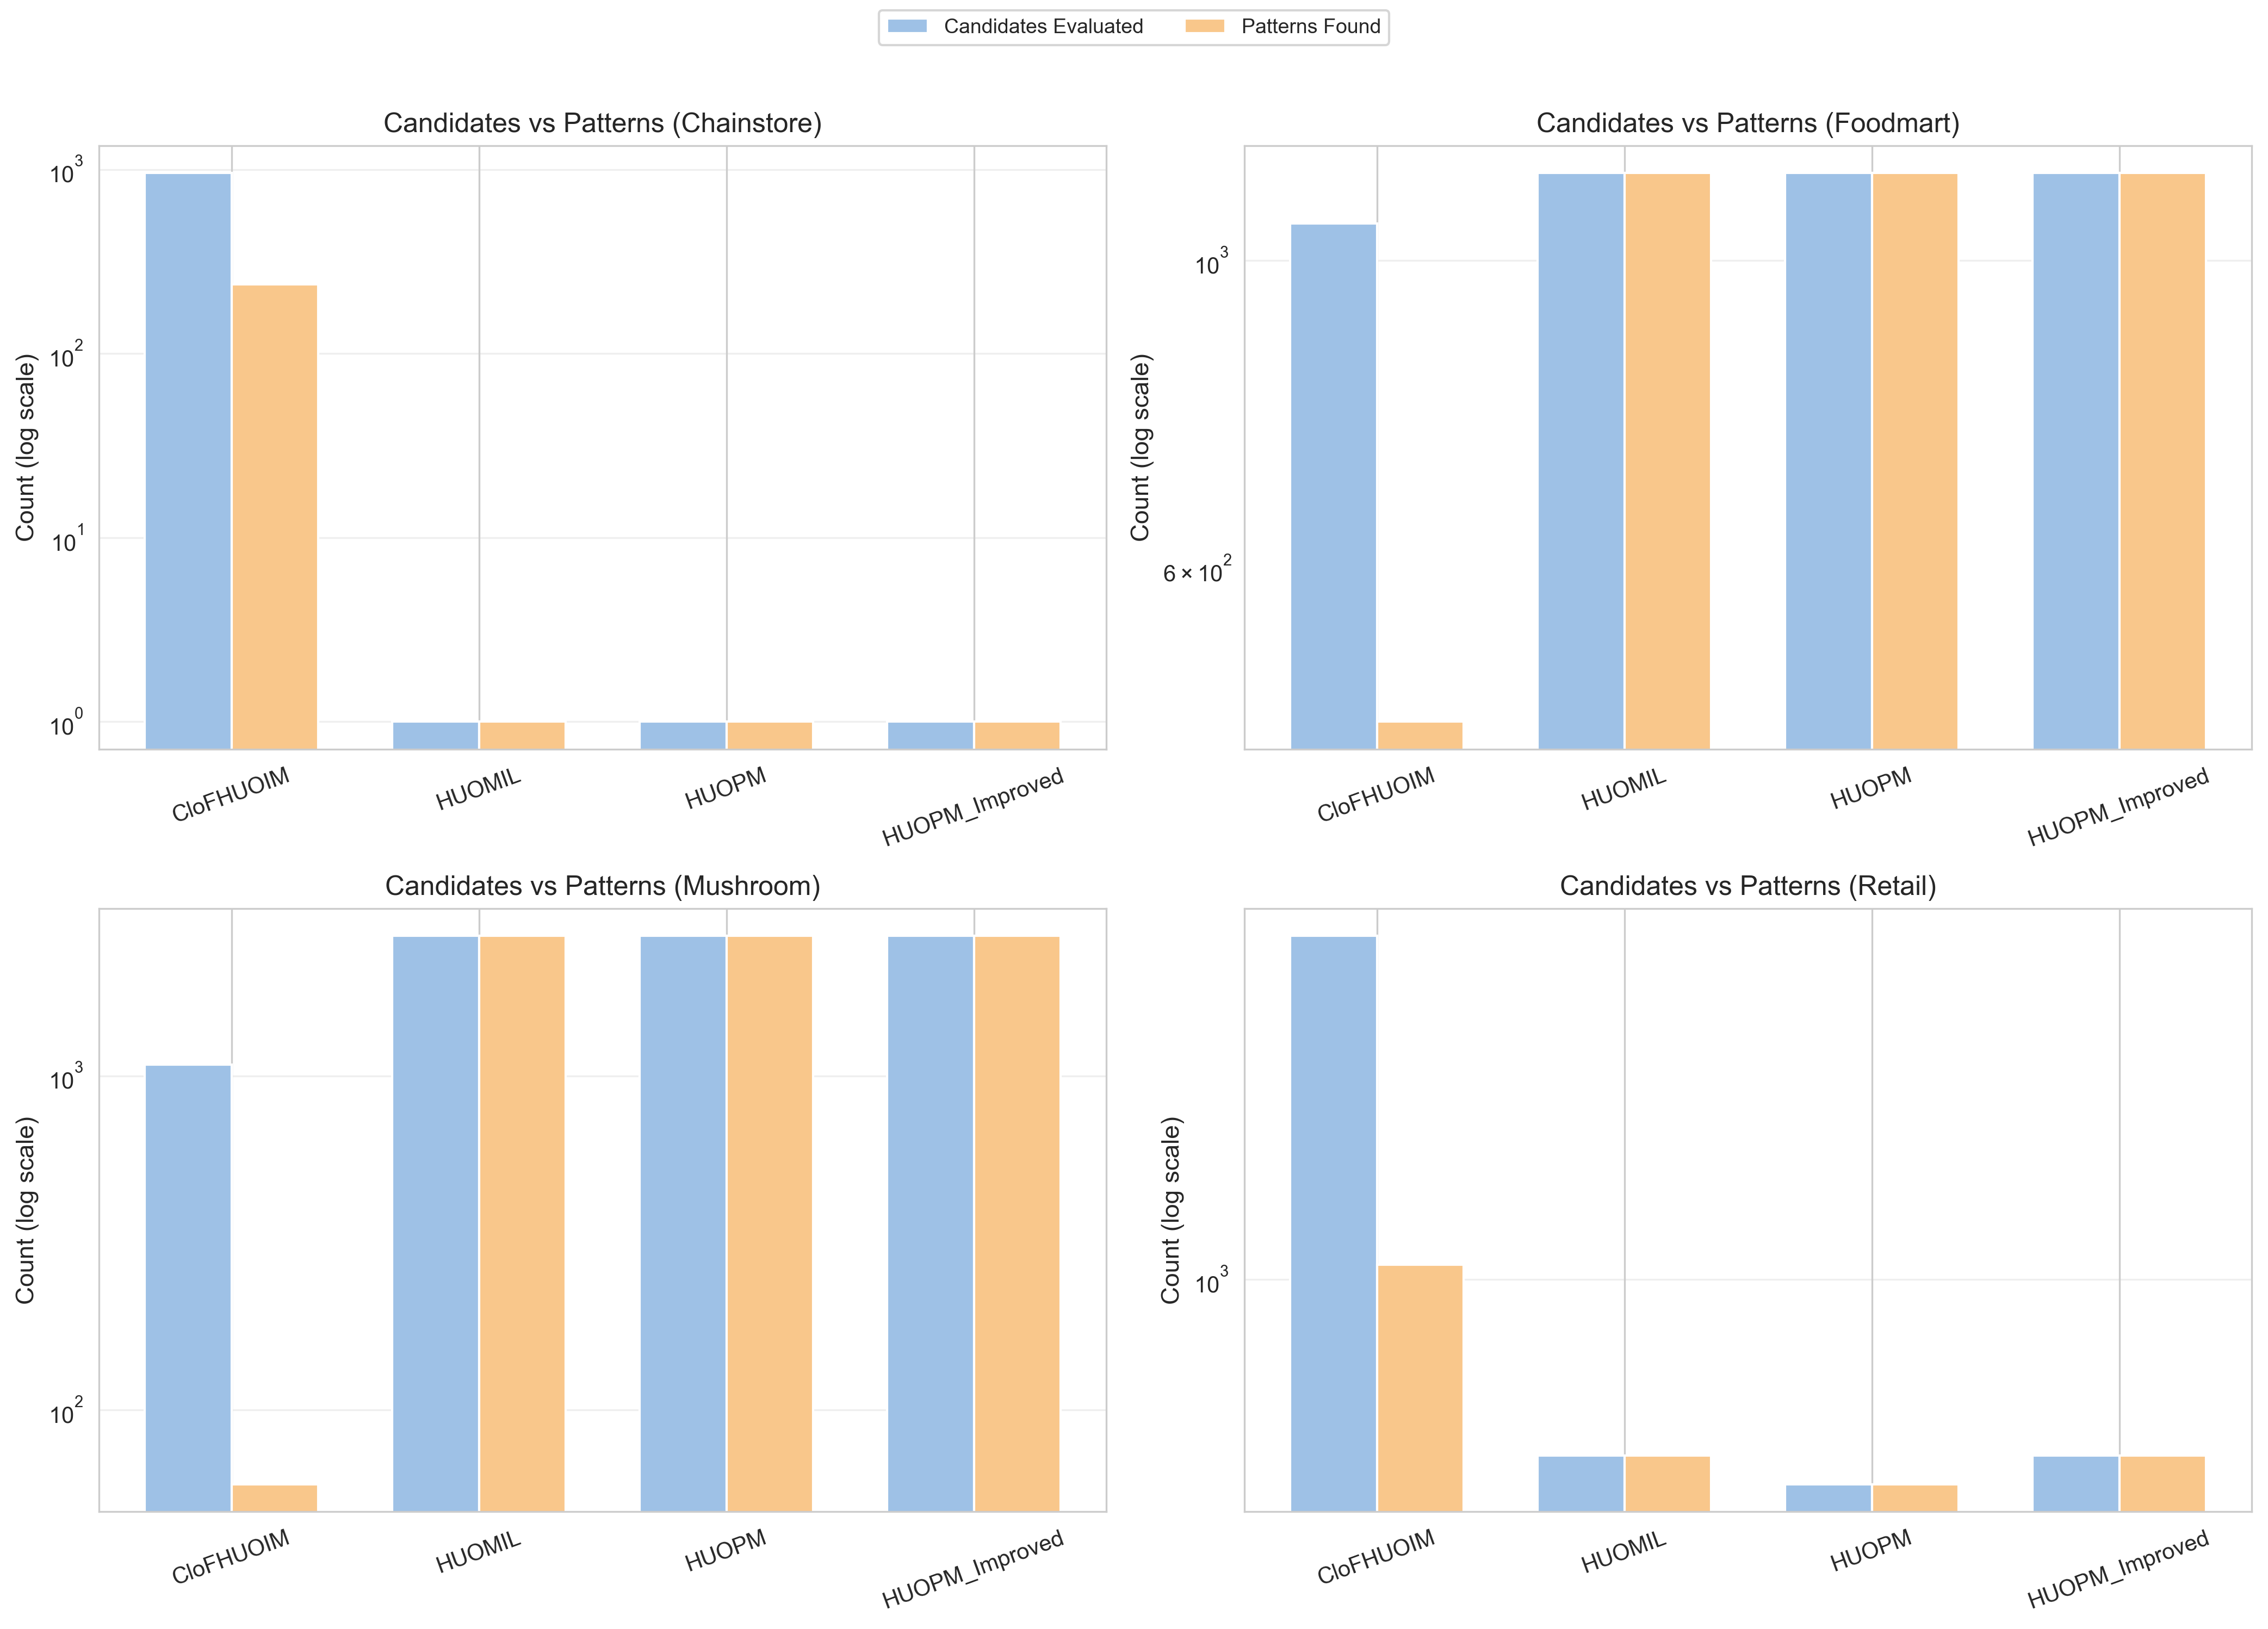

In [ ]:
# 5.5.1 Candidate Reduction Rates on Log Scale
combo_df = pd.concat([comp_df, concise_df], ignore_index=True)
algos = ['HUOPM', 'HUOMIL', 'HUOPM_Improved', 'CloFHUOIM']
datasets = sorted(combo_df['Dataset'].unique())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, dataset in enumerate(datasets):
    ax = axes[idx]

    subset = combo_df[
        (combo_df['Dataset'] == dataset) &
        (combo_df['Algorithm'].isin(algos))
    ]

    if subset.empty:
        ax.axis('off')
        continue

    agg = (
        subset.groupby('Algorithm')[['Candidates_Evaluated', 'Patterns_Found']]
        .mean()
        .reset_index()
    )

    x = range(len(agg))
    width = 0.35

    ax.bar(
        [p - width/2 for p in x],
        agg['Candidates_Evaluated'],
        width,
        label='Candidates Evaluated',
        color='#9EC1E6'
    )

    ax.bar(
        [p + width/2 for p in x],
        agg['Patterns_Found'],
        width,
        label='Patterns Found',
        color='#F9C78B'
    )

    ax.set_xticks(list(x))
    ax.set_xticklabels(agg['Algorithm'], rotation=20)
    ax.set_yscale('log')
    ax.set_ylabel('Count (log scale)')
    ax.set_title(f'Candidates vs Patterns ({dataset})')
    ax.grid(axis='y', alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Key takeaways**
- Exhaustive miners keep candidates close to patterns found.
- CloFHUOIM evaluates more candidates due to closure checks.
- Log scale highlights multi‑order magnitude differences across datasets.


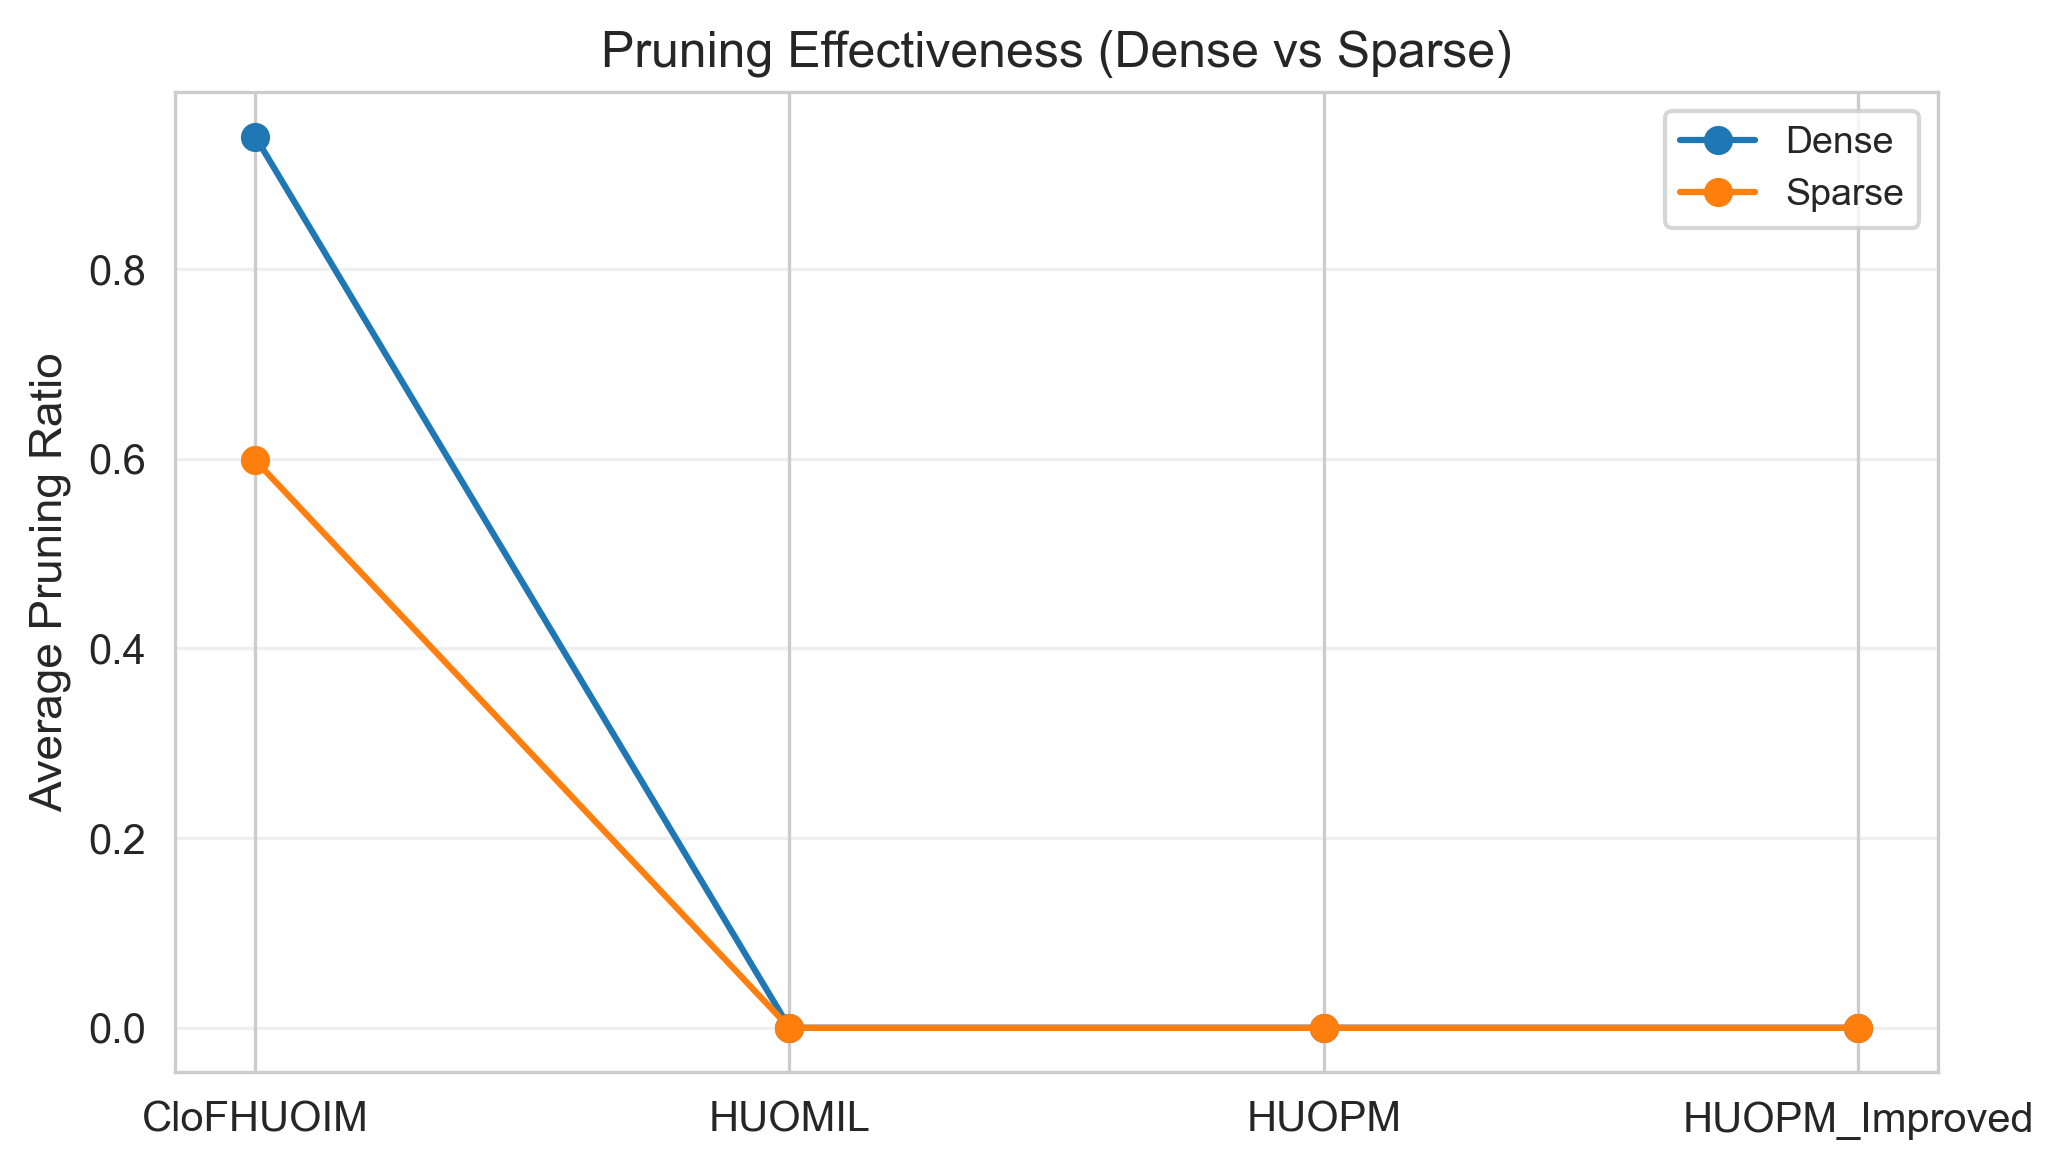

In [ ]:
# 5.5.2 Pruning Effectiveness Metrics across Dataset Densities
combo_df = pd.concat([comp_df, concise_df], ignore_index=True)
algos = ['HUOPM', 'HUOMIL', 'HUOPM_Improved', 'CloFHUOIM']

# Define dataset density groups
density_map = {
    'Mushroom': 'Dense',
    'Retail': 'Sparse',
    'Foodmart': 'Sparse',
    'Chainstore': 'Sparse'
}

combo_df['Density'] = combo_df['Dataset'].map(density_map)

# Calculate pruning ratio = (Candidates - Patterns) / Candidates
combo_df['Pruning_Ratio'] = (
    (combo_df['Candidates_Evaluated'] - combo_df['Patterns_Found'])
    / combo_df['Candidates_Evaluated'].replace(0, 1)
)

# Aggregate by density + algorithm
prune_stats = combo_df[combo_df['Algorithm'].isin(algos)] \
    .groupby(['Density', 'Algorithm'])['Pruning_Ratio'] \
    .mean().reset_index()

fig, ax = plt.subplots(figsize=(7, 4))
for density in ['Dense', 'Sparse']:
    sub = prune_stats[prune_stats['Density'] == density]
    ax.plot(sub['Algorithm'], sub['Pruning_Ratio'], marker='o', label=density)

ax.set_ylabel('Average Pruning Ratio')
ax.set_title('Pruning Effectiveness (Dense vs Sparse)')
ax.grid(axis='y', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

**Key takeaways**
- Dense datasets exhibit higher pruning ratios across algorithms.
- CloFHUOIM shows the highest ratios because of closure verification.


<a id="sec-5-6"></a>
# 5.6 Discovery Showcase


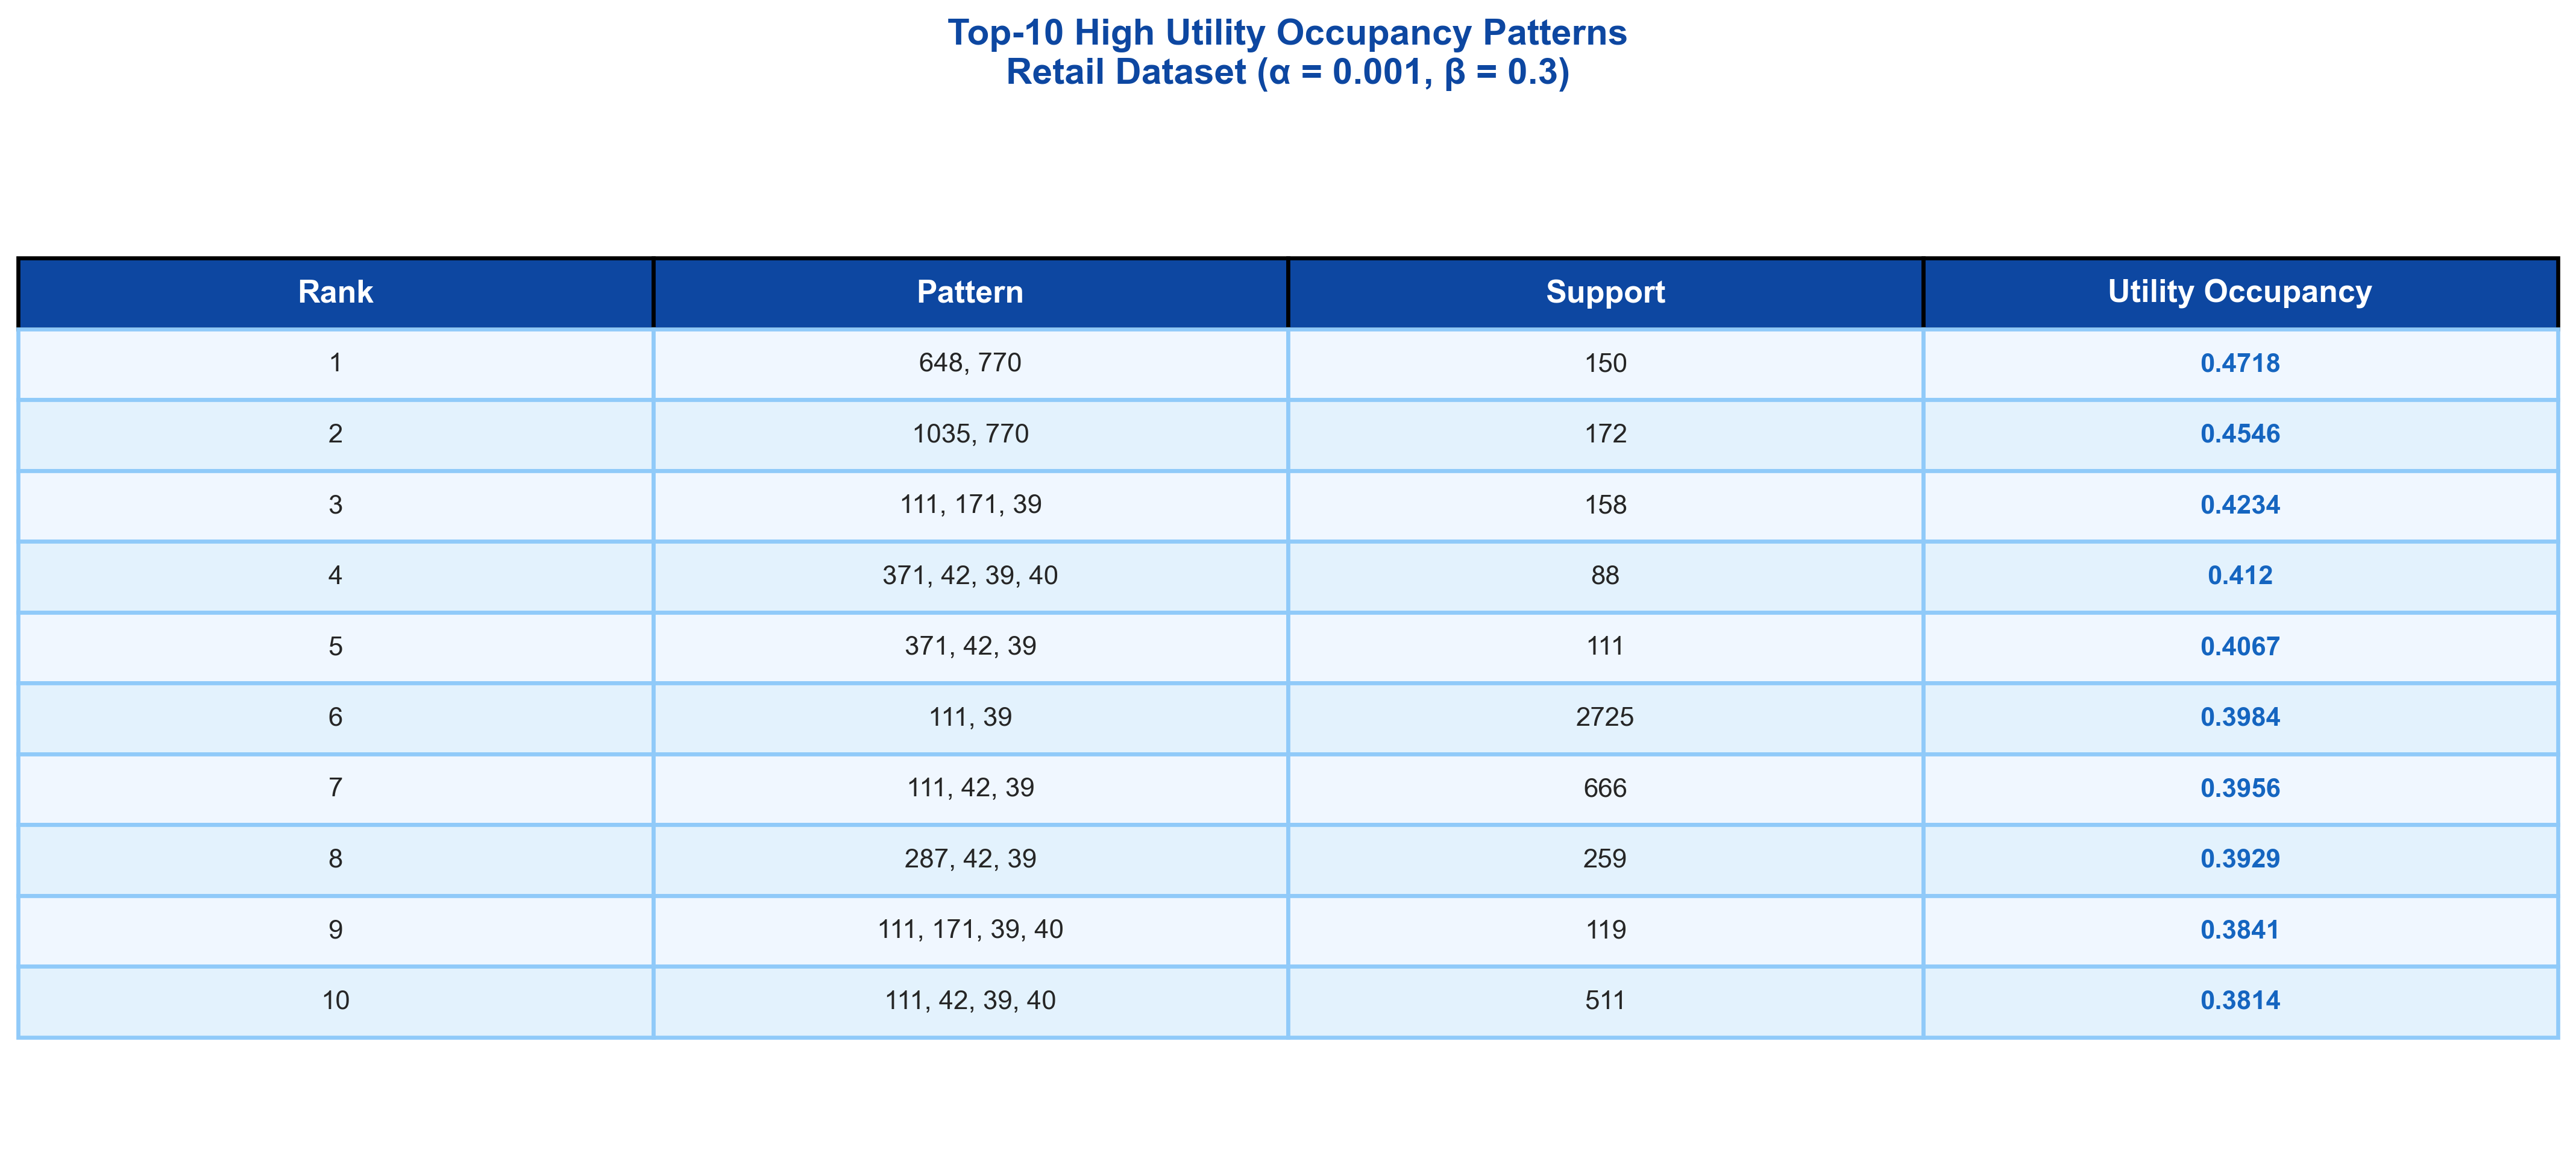

In [ ]:
path = RESULTS_DIR / 'comparison' / 'Retail' / 'HUOPM' / 'alpha_0.001_beta_0.3' / 'run-1.json'
data = json.loads(path.read_text())
patterns = data.get('Patterns', [])

# Sort by UO descending and take top 10
patterns_sorted = sorted(patterns, key=lambda x: x[2], reverse=True)[:10]

# Build DataFrame with Rank column
rows = []
for rank, (itemset, sup, uo) in enumerate(patterns_sorted, 1):
    rows.append({
        'Rank': rank,
        'Pattern': ', '.join(map(str, itemset)),
        'Support': sup,
        'Utility Occupancy': round(uo, 4)
    })

showcase_df = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(12.5, 7.2))
ax.axis('off')

table = ax.table(
    cellText=showcase_df.values,
    colLabels=showcase_df.columns,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10.5)
table.scale(1.45, 2.35)


for j in range(len(showcase_df.columns)):
    cell = table[0, j]
    cell.set_facecolor('#0d47a1')
    cell.set_text_props(color='white', weight='bold', size=12.5)


for i in range(1, len(showcase_df) + 1):
    row_color = '#f0f7ff' if i % 2 == 1 else '#e3f2fd'
    for j in range(len(showcase_df.columns)):
        cell = table[i, j]
        cell.set_facecolor(row_color)
        cell.set_edgecolor('#90caf9')
        
        # Highlight Utility Occupancy column
        if showcase_df.columns[j] == 'Utility Occupancy':
            cell.set_text_props(weight='bold', color='#1565c0')

for key, cell in table.get_celld().items():
    cell.set_linewidth(1.6)

# Title
plt.title("Top-10 High Utility Occupancy Patterns\n"
          "Retail Dataset (α = 0.001, β = 0.3)", 
          fontsize=14.5, fontweight='bold', color='#0d47a1', pad=25)
plt.show()

**Key takeaways**
- Top‑10 patterns illustrate dominant itemsets with high utility occupancy.
- Overlap among top patterns motivates concise mining in dense data.


<a id="sec-5-7"></a>
# 5.7 Top‑k Hybrid Summary


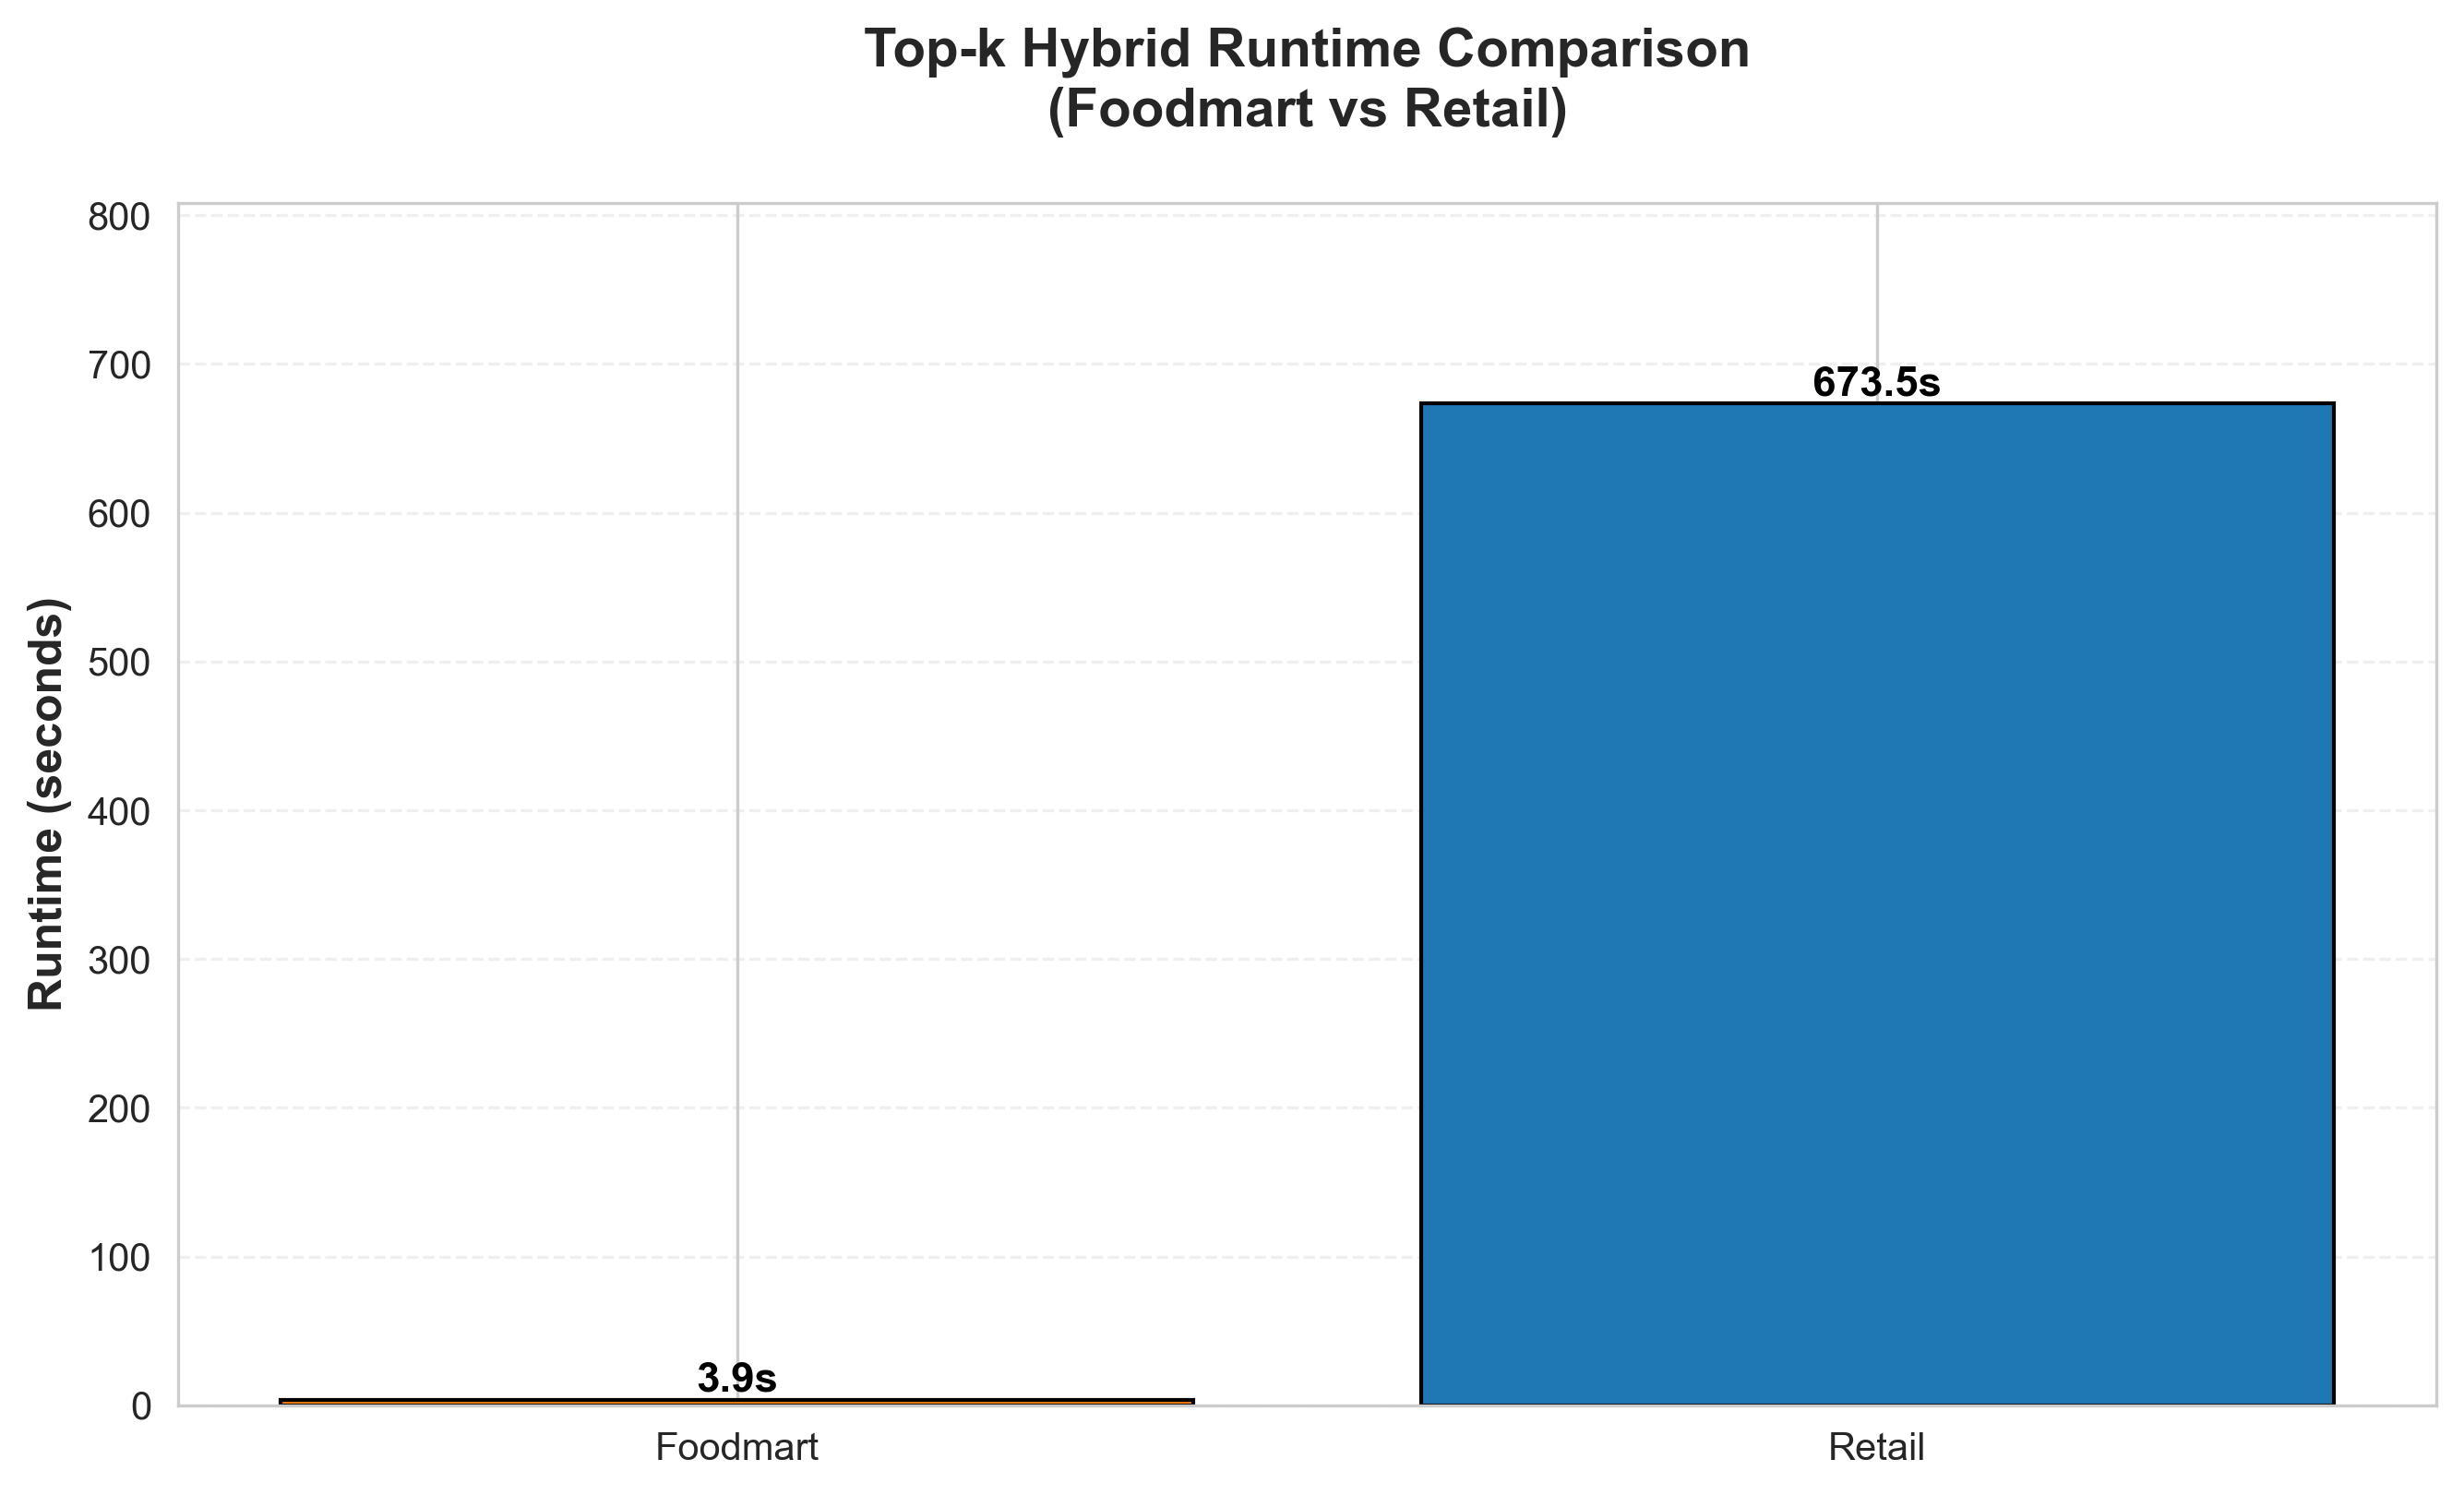

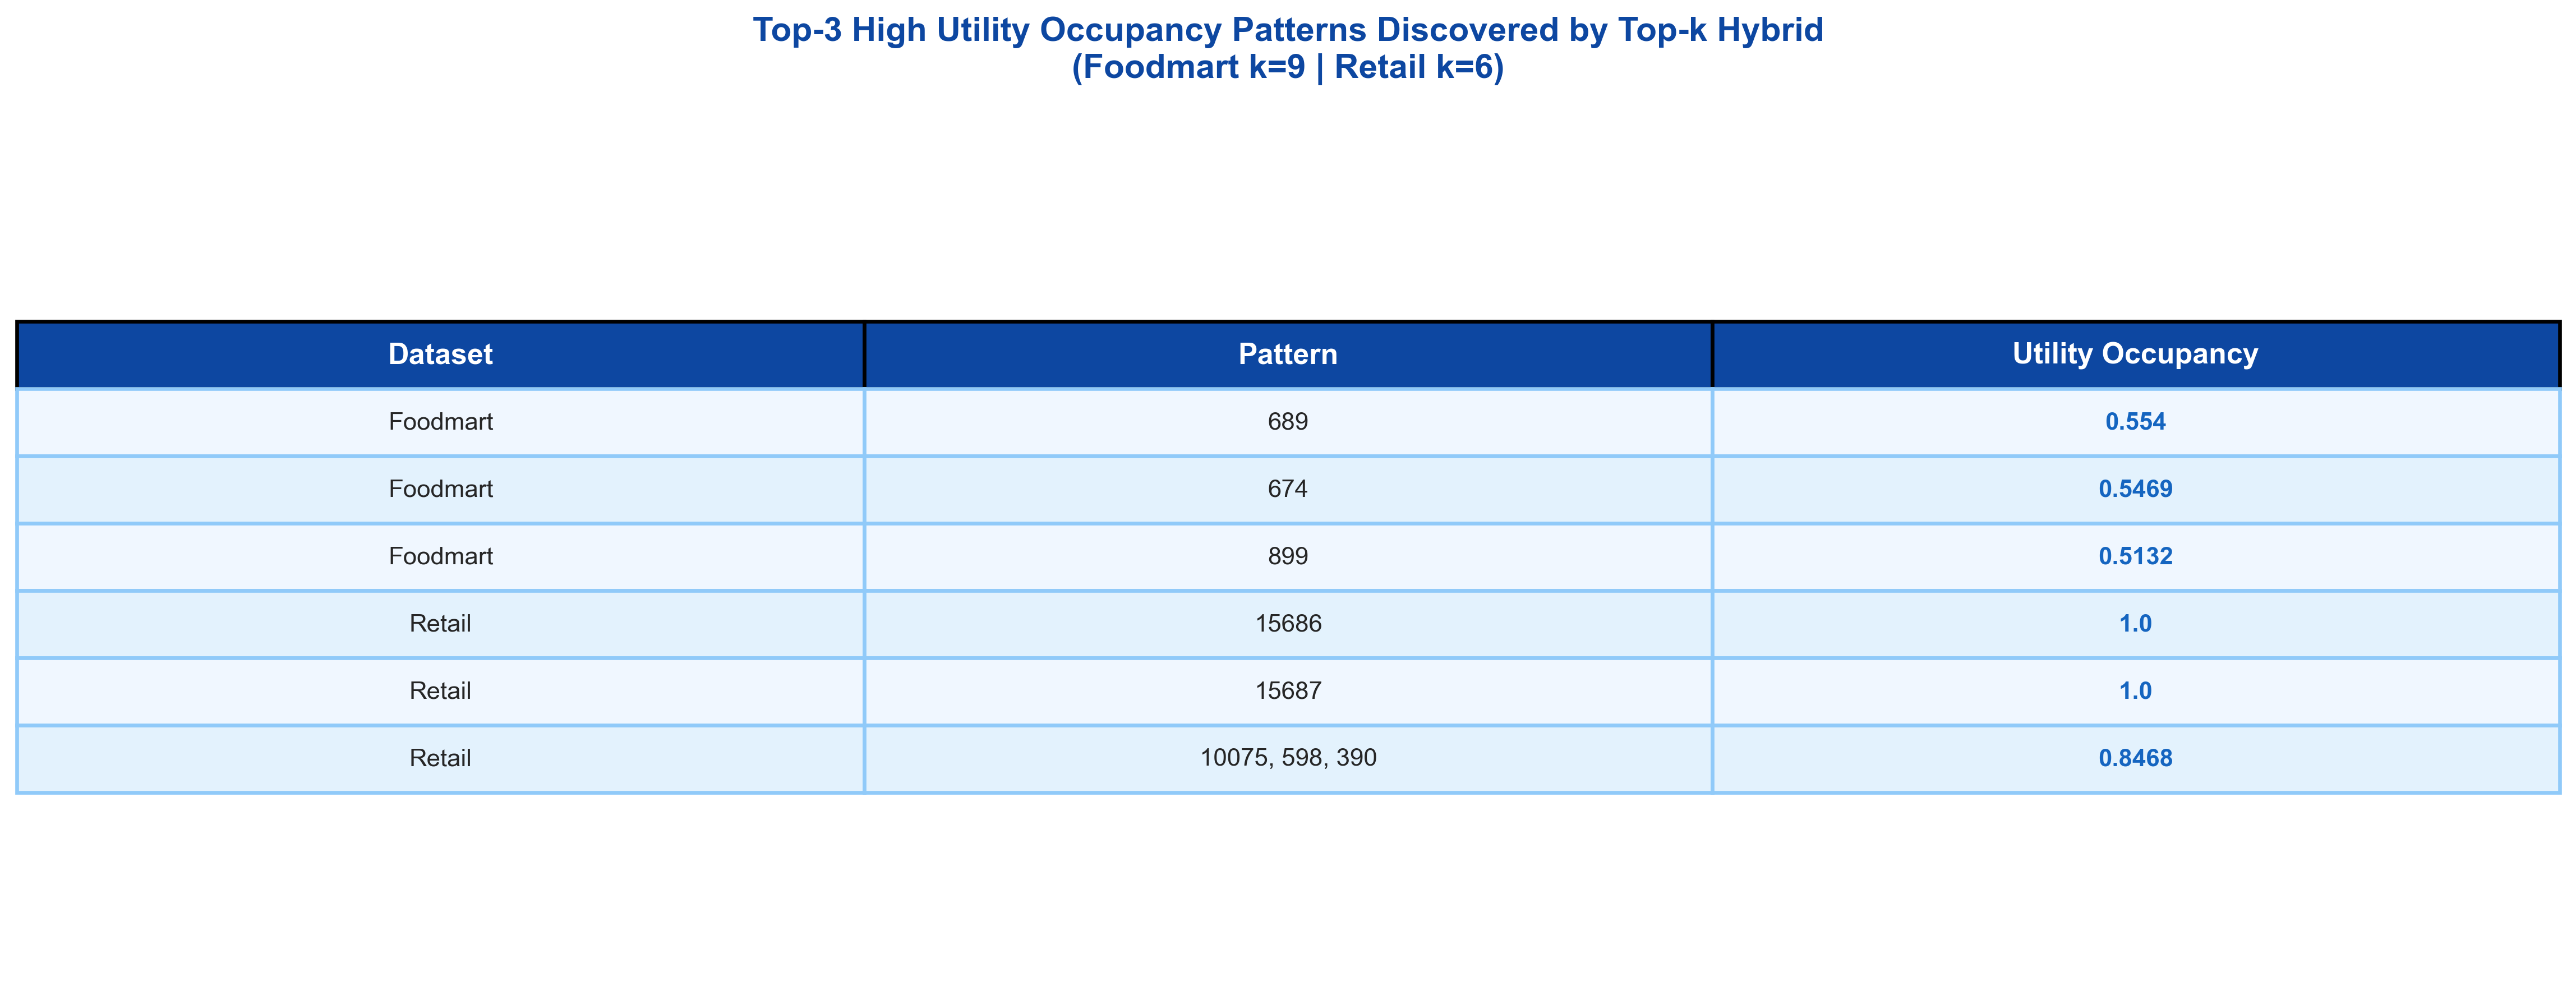

In [74]:
paths = [
    Path("results/topk_hybrid/HUOPM_Foodmart/k_9_ms_5/run-manual.json"),
    Path("results/topk_hybrid/HUOPM_Retail/k_6_ms_5/run-manual.json"),
]

# Load runtime summary
rows = []
patterns_table = []

for p in paths:
    data = json.loads(p.read_text())
    rows.append({
        "Dataset": data["Dataset"],
        "K": data["Params"]["k"],
        "ms": data["Params"]["ms"],
        "Runtime": data["Runtime"],
        "Patterns_Found": data["Patterns_Found"],
    })
    
    # Top 3 patterns per dataset
    for itemset, uo in data["Patterns"][:3]:
        patterns_table.append({
            "Dataset": data["Dataset"],
            "Pattern": ", ".join(itemset),
            "Utility Occupancy": round(uo, 4)
        })

df = pd.DataFrame(rows)

# IMPROVED RUNTIME BAR CHART
fig, ax = plt.subplots(figsize=(9, 5.5))
colors = ['#ff7f0e', '#1f77b4']

bars = ax.bar(df["Dataset"], df["Runtime"], color=colors, edgecolor='black', linewidth=1)

ax.set_ylabel("Runtime (seconds)", fontsize=12, fontweight='bold')
ax.set_title("Top-k Hybrid Runtime Comparison\n(Foodmart vs Retail)", 
             fontsize=14, fontweight='bold', pad=20)

for i, v in enumerate(df["Runtime"]):
    ax.text(i, v + 0.05, f"{v:.1f}s", ha='center', va='bottom', 
            fontsize=11, fontweight='bold', color='black')

ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(df["Runtime"]) * 1.2)

plt.tight_layout()
plt.show()

# TOP-3 PATTERNS TABLE 
patterns_df = pd.DataFrame(patterns_table)

fig, ax = plt.subplots(figsize=(13, 6.5))
ax.axis('off')

table = ax.table(
    cellText=patterns_df.values,
    colLabels=patterns_df.columns,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10.5)
table.scale(1.5, 2.4)

# Header
for j in range(len(patterns_df.columns)):
    cell = table[0, j]
    cell.set_facecolor('#0d47a1')
    cell.set_text_props(color='white', weight='bold', size=12.5)

# Body - alternating rows + bold UO
for i in range(1, len(patterns_df) + 1):
    row_color = '#f0f7ff' if i % 2 == 1 else '#e3f2fd'
    for j in range(len(patterns_df.columns)):
        cell = table[i, j]
        cell.set_facecolor(row_color)
        cell.set_edgecolor('#90caf9')
        if patterns_df.columns[j] == 'Utility Occupancy':
            cell.set_text_props(weight='bold', color='#1565c0')

for key, cell in table.get_celld().items():
    cell.set_linewidth(1.6)

plt.title("Top-3 High Utility Occupancy Patterns Discovered by Top-k Hybrid\n"
          "(Foodmart k=9 | Retail k=6)", 
          fontsize=14.5, fontweight='bold', color='#0d47a1', pad=25)
plt.show()

**Key takeaways**
- Top‑k Hybrid highlights highest‑occupancy patterns without manual β tuning.
- Runtime grows with dataset scale, but best‑first search prunes aggressively.
